# CIND820 Analytics Project
# Controlling a Pandemic: Analyzing Key Factors in COVID-19 Outcomes by Country
Dataset: Our world in COVID-19
https://github.com/owid/covid-19-data/raw/master/public/
- this dataset is an amalgamate of many government data sources and John Hopkins University Research Center
- Dataset Codebook is available at the above github link

## Project Purpose
- This project is to shed light on the different attributes that may affect COVID spread and fatalities
- The aim is to discover the important trends, and find the most important demographic factors through visual trend analysis
- Another goal of this project is to develop an ARIMA model to forecast cases and deaths for Canada for the next 30 days
- This project will heavily focus on visualizations and EDA, with some Data Mining to gather most of the insight

In [594]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
import itertools
import warnings
warnings.simplefilter('ignore')

#Visualization
#!pip install plotly_express
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling and evaluation
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

sns.set_style("darkgrid")

In [595]:
OWIDdf = pd.read_csv('https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv')

In [596]:
OWIDdfc = OWIDdf.copy()

In [829]:
OWIDdfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79880 entries, 0 to 79879
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               79880 non-null  object 
 1   continent                              75985 non-null  object 
 2   location                               79880 non-null  object 
 3   date                                   79880 non-null  object 
 4   total_cases                            78296 non-null  float64
 5   new_cases                              78294 non-null  float64
 6   new_cases_smoothed                     77293 non-null  float64
 7   total_deaths                           68838 non-null  float64
 8   new_deaths                             68996 non-null  float64
 9   new_deaths_smoothed                    77293 non-null  float64
 10  total_cases_per_million                77871 non-null  float64
 11  ne

# Data Cleaning

- columns will be removed based on relevance, and multicollinearity
- due to the data being relatively recent, with varying underreporting rates by region, some data is unavailable
- however it is difficult to eliminate variables by NA values alone
- each variable even with relatively little rows can still be valuable for visual analysis
- some columns have less than 10000 non-null values, but may be kept due to high relevance. ie. new vaccinations, 


In [597]:
OWIDdfc.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1      AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0        1803.987              NaN                597.029   
1        1803.987              NaN                597.029   
2        1803.987              NaN                597.029   
3        1803.987              NaN                597.029   
4        1803.987              NaN                597.029   

   diabetes_prevalence  female_smokers  male_smokers  handwashing_facilities  \
0                 9.59             NaN           NaN                  37.746   
1                 9.59             NaN           NaN                  37.746   
2                 9.59             NaN           NaN                  37.746   
3                 9.59             NaN           NaN                  37.746   
4                 9.59             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  
0                         0.5            64.83                    0.511  
1                         0.5            64.83                    0.511  
2                         0.5            64.83                    0.511  
3                         0.5            64.83                    0.511  
4                         0.5            64.83                    0.511  

[5 rows x 59 columns]

In [598]:
OWIDdfc.describe()
#many nonsensical negative values like -min in new_deaths columns.

total_cases      new_cases  new_cases_smoothed  total_deaths  \
count  7.829600e+04   78294.000000        77293.000000  6.883800e+04   
mean   7.357568e+05    5394.893095         5394.395496  2.112915e+04   
std    5.123485e+06   33256.781489        32850.632726  1.243785e+05   
min    1.000000e+00  -74347.000000        -6223.000000  1.000000e+00   
25%    8.327500e+02       2.000000            6.429000  4.200000e+01   
50%    9.068500e+03      65.000000           78.714000  2.820000e+02   
75%    9.845100e+04     714.000000          746.857000  2.756000e+03   
max    1.324191e+08  880812.000000       739642.714000  2.872453e+06   

         new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  68996.000000         77293.000000             77871.000000   
mean     134.021349           118.486575              8868.249364   
std      730.743062           669.099550             17240.060352   
min    -1918.000000          -232.143000                 0.001000   
25%        0.000000             0.000000               176.514000   
50%        2.000000             1.143000              1221.038000   
75%       17.000000            12.857000              8500.946500   
max    17904.000000         14432.857000            159554.779000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count           77869.000000                    76873.000000   
mean               70.956460                       70.896569   
std               173.564711                      146.785494   
min             -2153.437000                     -276.825000   
25%                 0.168000                        1.078000   
50%                 7.019000                        9.250000   
75%                62.193000                       69.967000   
max              8652.658000                     2648.773000   

       total_deaths_per_million  ...  gdp_per_capita  extreme_poverty  \
count              68426.000000  ...    72521.000000     49463.000000   
mean                 202.921792  ...    19134.919094        13.309666   
std                  358.111868  ...    19781.440853        19.928169   
min                    0.001000  ...      661.240000         0.100000   
25%                    6.210000  ...     4466.507000         0.500000   
50%                   35.386500  ...    12951.839000         2.000000   
75%                  216.721250  ...    27216.445000        21.200000   
max                 2537.029000  ...   116935.600000        77.600000   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
count           73119.000000         74089.000000    57394.000000   
mean              257.504198             7.808301       10.528259   
std               118.665165             3.956814       10.402944   
min                79.370000             0.990000        0.100000   
25%               167.295000             5.290000        1.900000   
50%               242.648000             7.110000        6.300000   
75%               329.635000            10.080000       19.300000   
max               724.417000            30.530000       44.000000   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
count  56546.000000            36727.000000                66837.000000   
mean      32.652706               50.956286                    3.031714   
std       13.473291               31.765397                    2.465208   
min        7.700000                1.188000                    0.100000   
25%       21.600000               20.859000                    1.300000   
50%       31.400000               49.839000                    2.400000   
75%       41.100000               83.241000                    3.861000   
max       78.100000               98.999000                   13.800000   

       life_expectancy  human_development_index  
count     75834.000000             73059.000000  
mean         73.154804                 0.727460  
std           7.551337                 0.150068  
min 

## Negative Data 
- some columns have negative data: new_cases_ columns
- the codebook does not mention any reasons for negative data so it is assumed to be typoes and filtered out

In [599]:
df = OWIDdfc.copy()
df.new_cases.min()

-74347.0

Absolute values of columns with negative values

In [600]:
#new_cols = [col for col in df.columns if 'new' in col]
#new_cols

#df[new_cols] = abs(df[new_cols])

#df[new_cols].describe()

In [604]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79880 entries, 0 to 79879
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               79880 non-null  object 
 1   continent                              75985 non-null  object 
 2   location                               79880 non-null  object 
 3   date                                   79880 non-null  object 
 4   total_cases                            78296 non-null  float64
 5   new_cases                              78294 non-null  float64
 6   new_cases_smoothed                     77293 non-null  float64
 7   total_deaths                           68838 non-null  float64
 8   new_deaths                             68996 non-null  float64
 9   new_deaths_smoothed                    77293 non-null  float64
 10  total_cases_per_million                77871 non-null  float64
 11  ne

In [605]:
#some of this information is too sparse to analyse, and is somewhat redundant when we are already analysing death rates
df.drop(columns=df.columns[17:25].tolist(), inplace=True)

In [606]:
df_dropcol = df.copy()

In [607]:
#date indexing
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [609]:
df_world = df[df.location=='World']
df = df[-df.location.isin(['World'])]

# Exploratory Data Analysis

[Text(0, 0.5, 'Deaths'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Global Daily Deaths Mar-2020 to Apr-2021')]

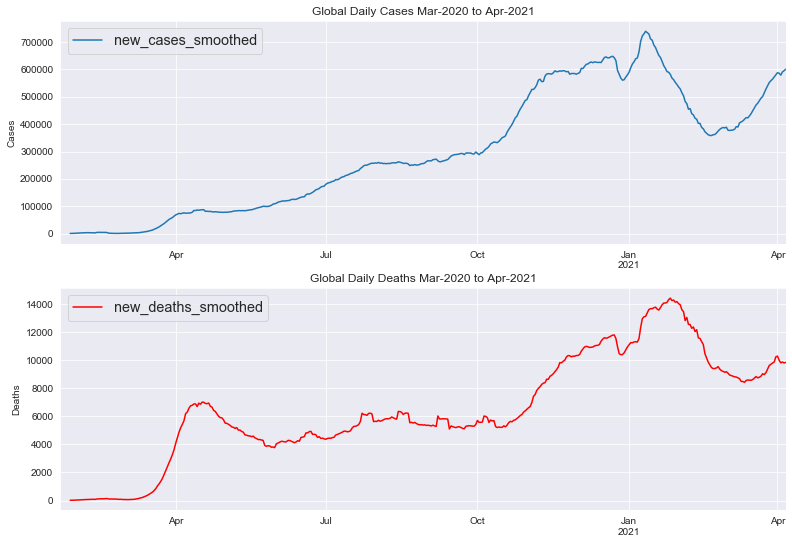

In [837]:
fig, ax = plt.subplots(2,1,figsize=(13,9))
for x, y in enumerate([df_world.new_cases_smoothed]):
    y.plot(ax=ax[0], linestyle='-')
for x, y in enumerate([df_world.new_deaths_smoothed]):
    y.plot(ax=ax[1], linestyle='-', color='r')
    
ax[0].legend(fontsize='x-large')
ax[0].set(xlabel = '', ylabel='Cases', title = 'Global Daily Cases Mar-2020 to Apr-2021')
ax[1].legend(fontsize='x-large')
ax[1].set(xlabel = '', ylabel='Deaths', title = 'Global Daily Deaths Mar-2020 to Apr-2021')

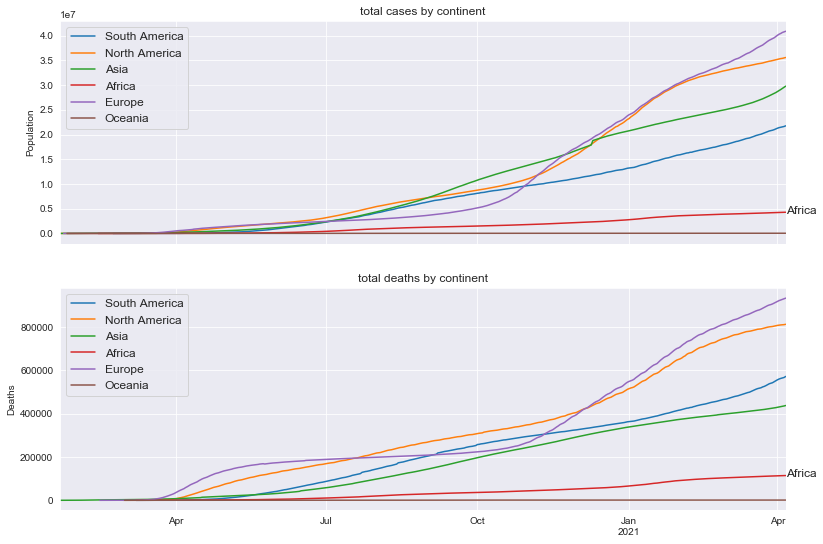

In [946]:
fig, ax = plt.subplots(2, 1, figsize=(13,9), sharex=True)
continents = ['South America','North America','Asia','Africa','Europe','Oceania']#No Antarctica information available

for i in continents:
    for x, y in enumerate([odf[odf.location==i].total_cases]):
        y.plot(ax=ax[0], linestyle='-')
ax[0].set(xlabel = '', ylabel='Population', title = 'total cases by continent')  
ax[0].annotate('Africa', xy=(odf.index.max(),4000000), fontsize=12)
ax[0].legend(continents, fontsize='large')


for i in continents:
    for x, y in enumerate([odf[odf.location==i].total_deaths]):
        y.plot(ax=ax[1], linestyle='-')
ax[1].set(xlabel = '', ylabel='Deaths', title = 'total deaths by continent') 
ax[1].annotate('Africa', xy=(odf.index.max(),110000), fontsize=12)
ax[1].legend(continents, loc='upper left',fontsize= 'large')

In [21]:
odf_canada = odf[odf.location=='Canada']

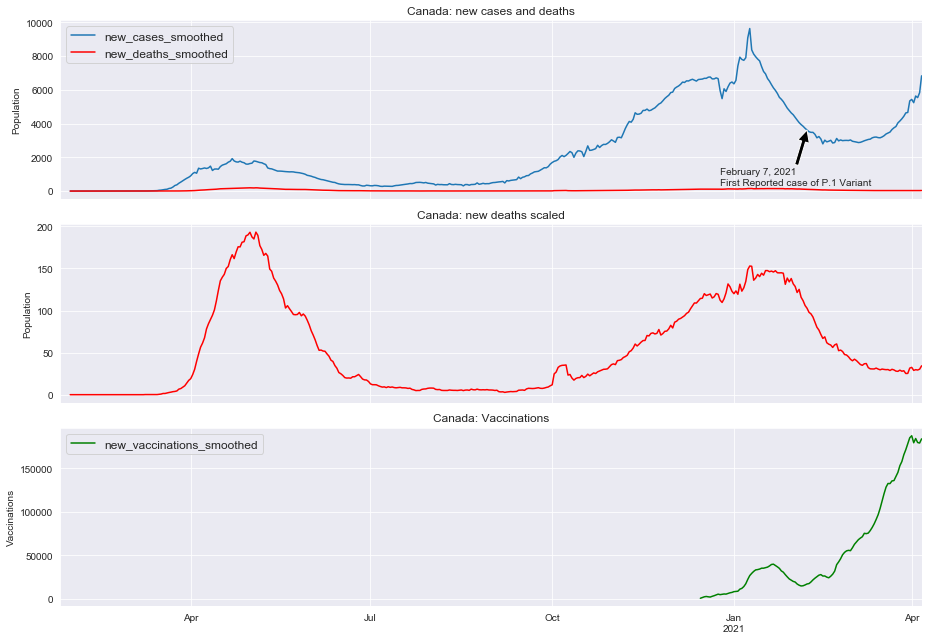

In [555]:
fig, ax = plt.subplots(3, 1, figsize=(13,9), sharex=True)
for x, y in enumerate([odf_canada.new_cases_smoothed]):
    y.plot(ax=ax[0], linestyle='-')
for x, y in enumerate([odf_canada.new_deaths_smoothed]):
    y.plot(ax=ax[0], linestyle='-', color='r')
for x, y in enumerate([odf_canada.new_deaths_smoothed]):
    y.plot(ax=ax[1], linestyle='-', color='r')
for x, y in enumerate([odf_canada.new_vaccinations_smoothed]):
    y.plot(ax=ax[2], linestyle='-', color='g')  

ax[0].set(xlabel = '', ylabel='Population', title = 'Canada: new cases and deaths')
ax[1].set(xlabel = '', ylabel='Population', title = 'Canada: new deaths scaled')
ax[2].set(xlabel = '', ylabel='Vaccinations', title = 'Canada: Vaccinations')

ax[0].legend(loc='upper left', fontsize='large')
ax[2].legend(loc='upper left', fontsize='large')
ax[0].annotate('February 7, 2021\nFirst Reported case of P.1 Variant',
               xy=('2021-02-07', odf_canada.new_cases_smoothed['2021-02-07']),
               xycoords = 'data', xytext=('2020-12-25',1400),
               arrowprops=dict(facecolor='black'),
               horizontalalignment='left',
               verticalalignment='top')

plt.tight_layout()

## Vaccinations vs Deaths
- it is difficult to see a clear trend because the world only had access to vaccines fairly recently
- the effects of large scale vaccinations will take a longer time-frame to visualize a clear effect

In [ ]:
def timeplot(loc, case1, case2):
    fig, ax = plt.subplots(figsize=(14,7))
    for x, y in enumerate([df[df.location==loc][case1]]):
        y.plot(ax=ax, linestyle='-')
    for x, y in enumerate([df[df.location==loc][case2]]):
        y.plot(ax=ax, linestyle='-', color = 'r')
    #for x, y in enumerate([odf_canada.total_tests]):
    #    y.plot(ax=ax, linestyle='-')
    #for x, y in enumerate([odf_canada.total_vaccinations]):
    #    y.plot(ax=ax, linestyle='-')

    ax.set_title(''+case1+' vs '+case2, fontsize='xx-large')
    ax.legend(loc = 'upper left', fontsize='x-large')

In [556]:
def vtplot(case='Canada'):
    
    fig, host = plt.subplots(figsize=(12,8))
    par1 = host.twinx()
    par1.set_ylim(auto=True)

    host.set_ylabel('Total cases and vaccinations', fontsize=14)
    par1.set_ylabel('Total deaths', fontsize=14)

    for x, y in enumerate([df[df.location==case].total_cases.dropna()]):
        y.plot(ax=host, linestyle='-')
    for x, y in enumerate([df[df.location==case].total_deaths.dropna()]):
        y.plot(ax=par1, linestyle='--', color = 'r')
    for x, y in enumerate([df[df.location==case].total_vaccinations.dropna()]):
        y.plot(ax=host, linestyle='-', color='g')
    host.legend(labels=['total_cases','total_vaccinations'], loc='upper left', fontsize='x-large')
    par1.legend(labels=['total_deaths'], loc='upper right', fontsize='x-large')

    host.set_title(case, fontsize='xx-large')

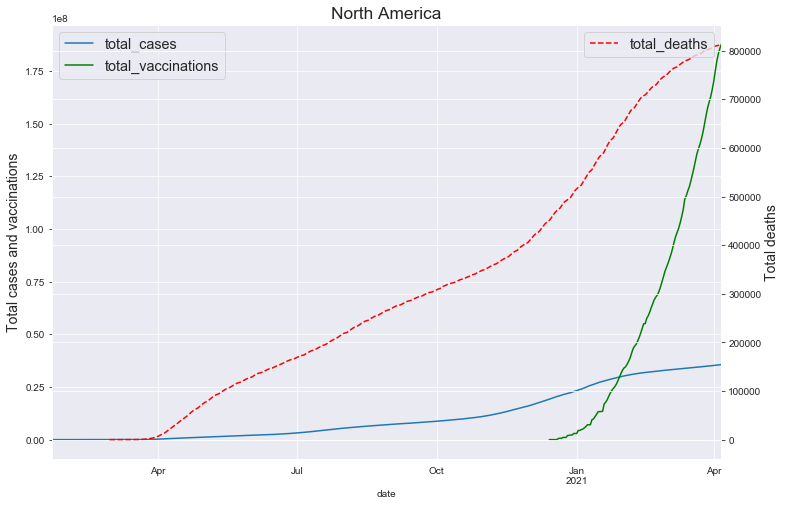

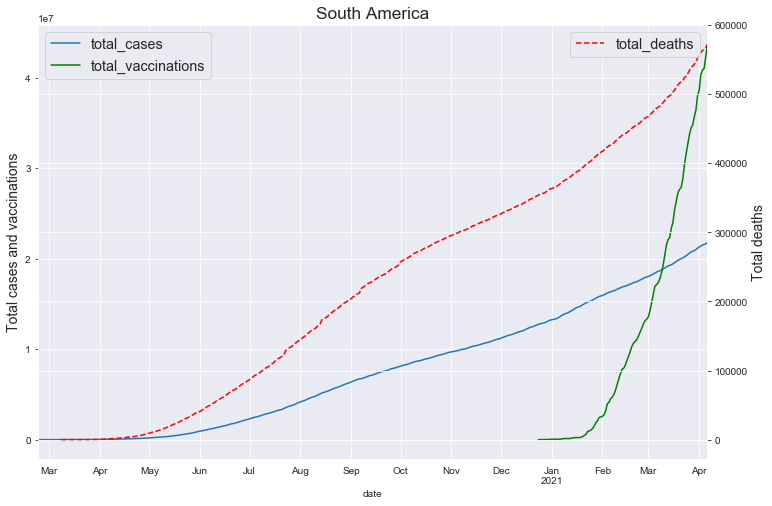

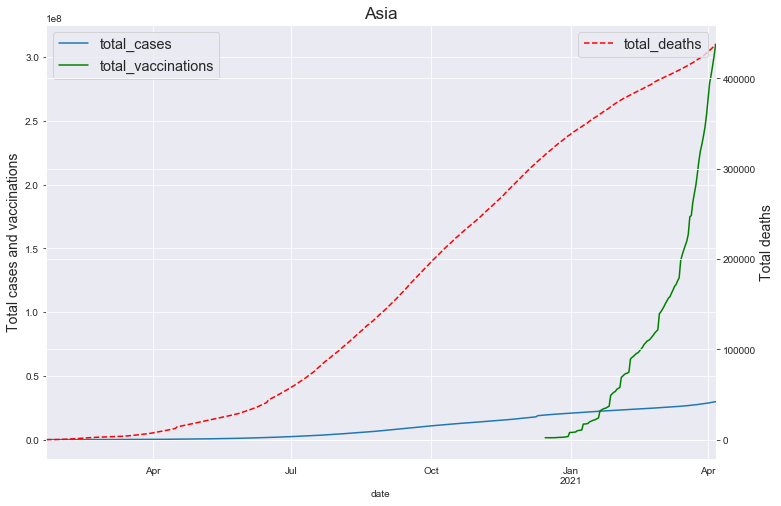

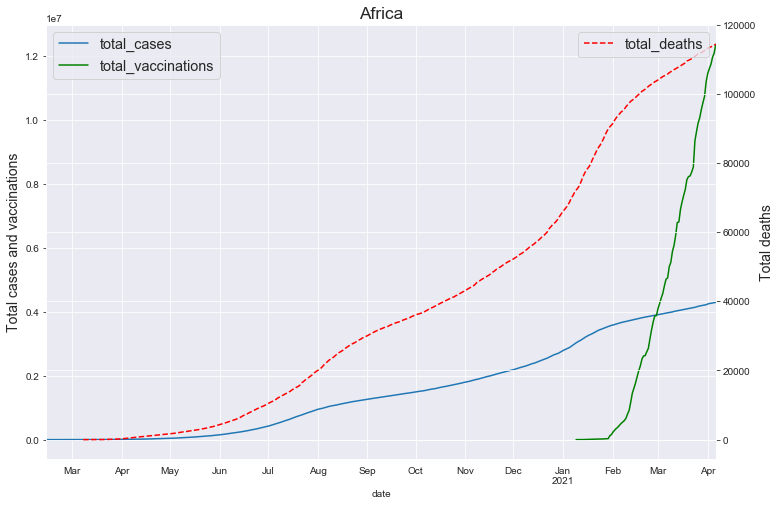

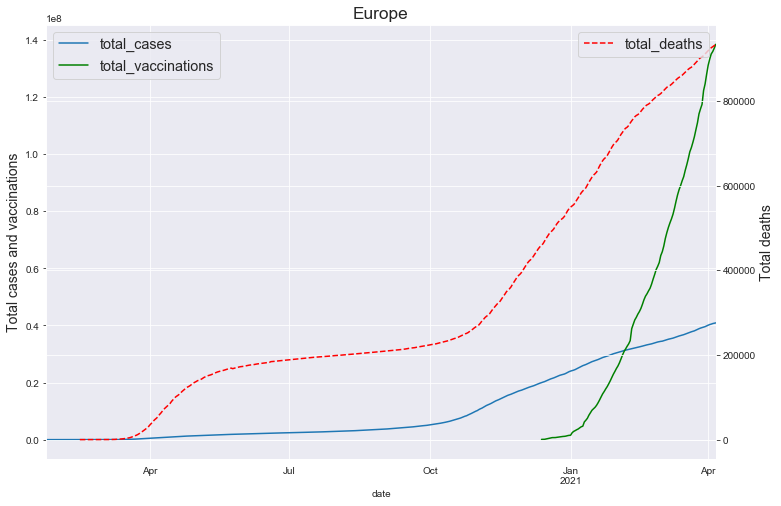

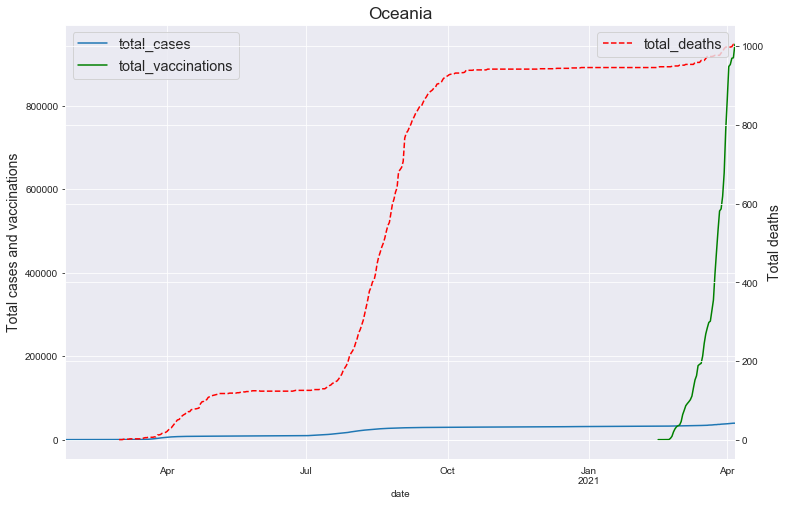

In [557]:
vtplot('North America')
vtplot('South America')
vtplot('Asia')
vtplot('Africa')
vtplot('Europe')
vtplot('Oceania')

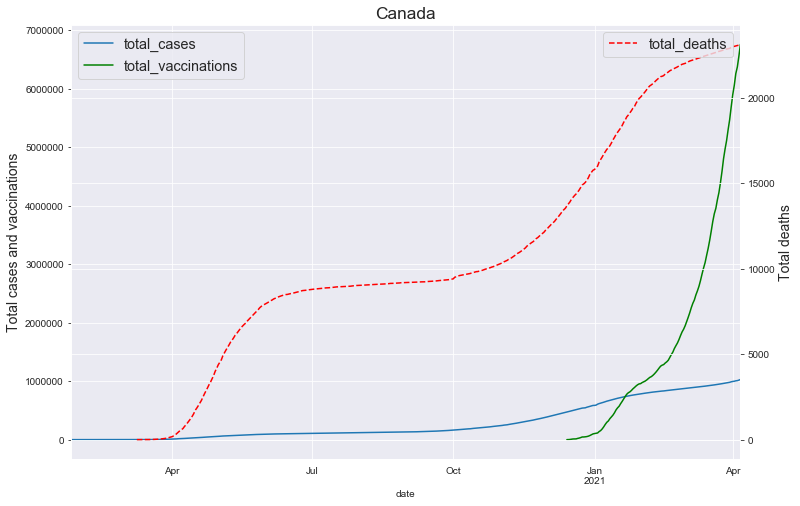

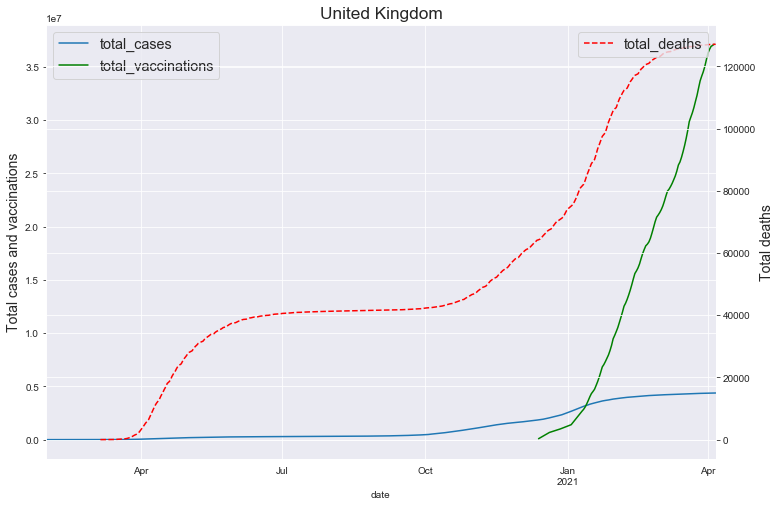

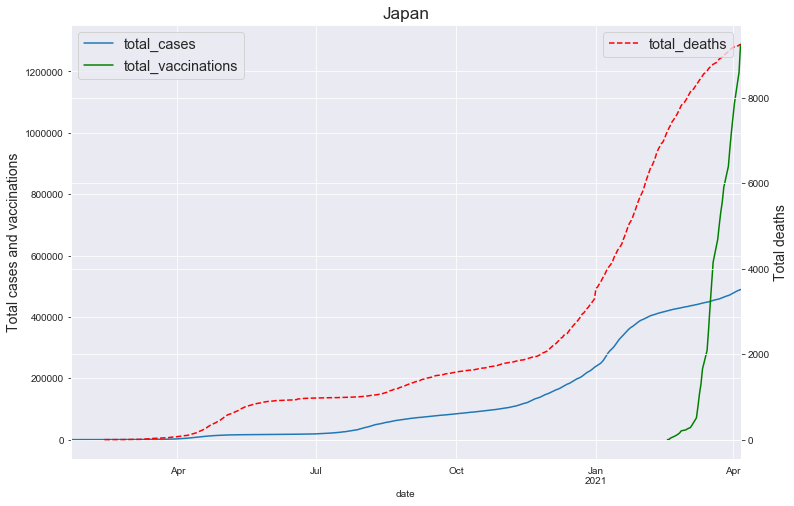

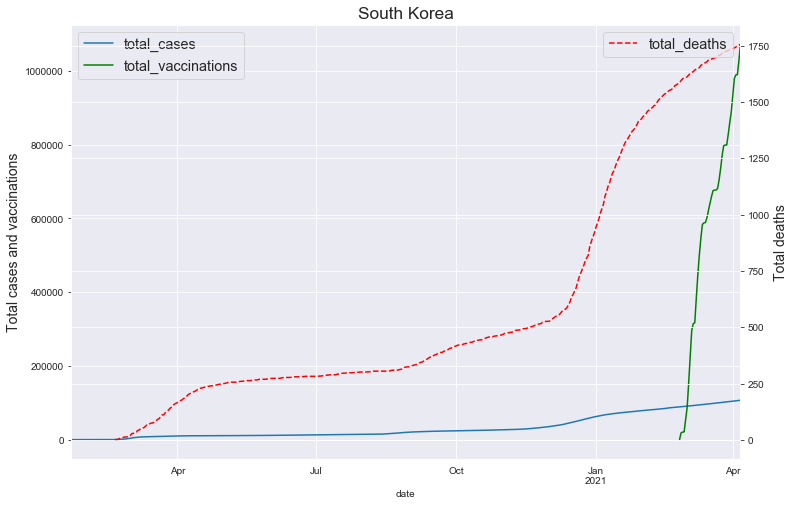

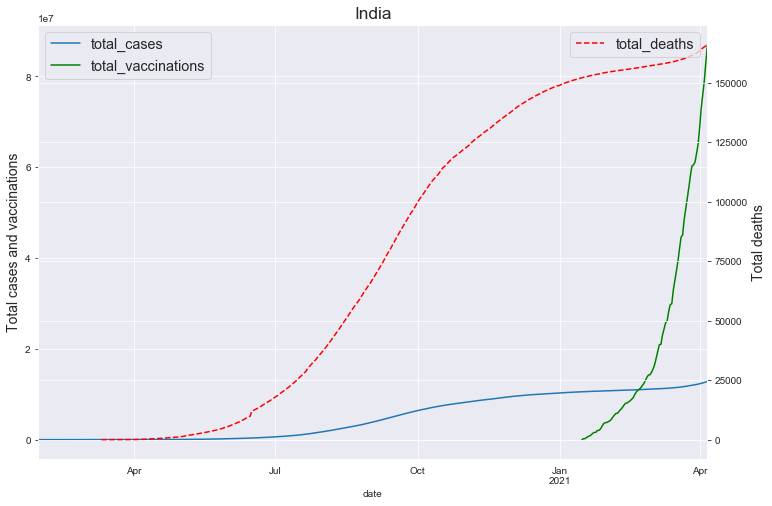

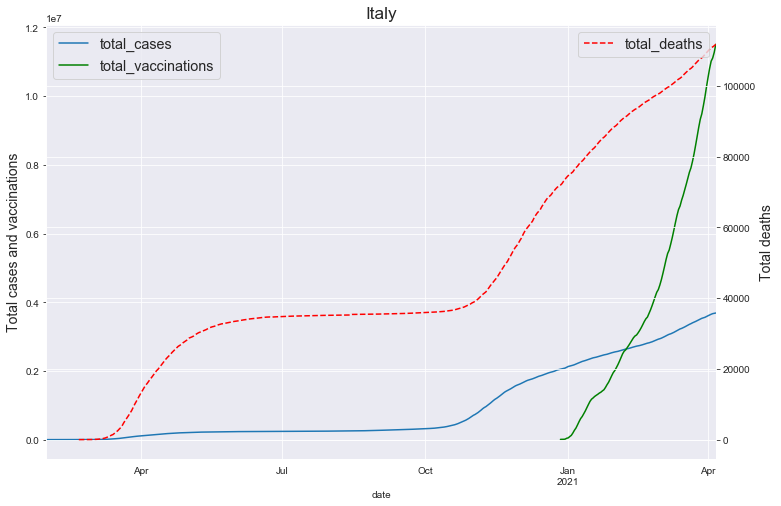

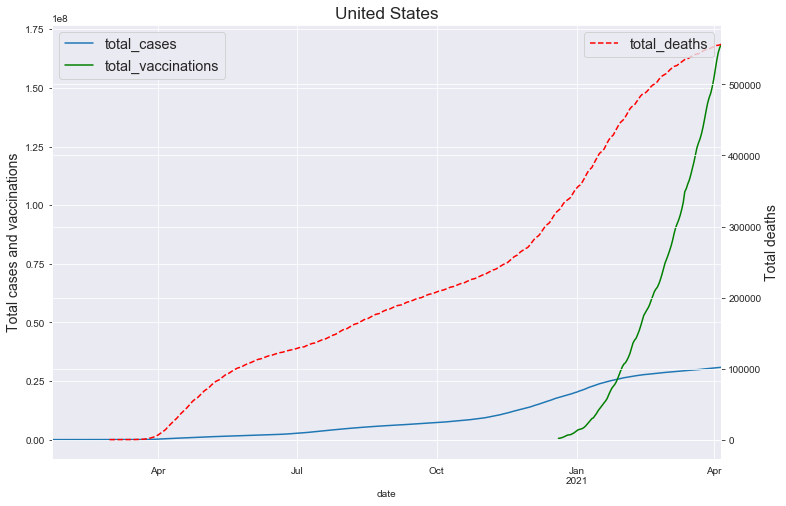

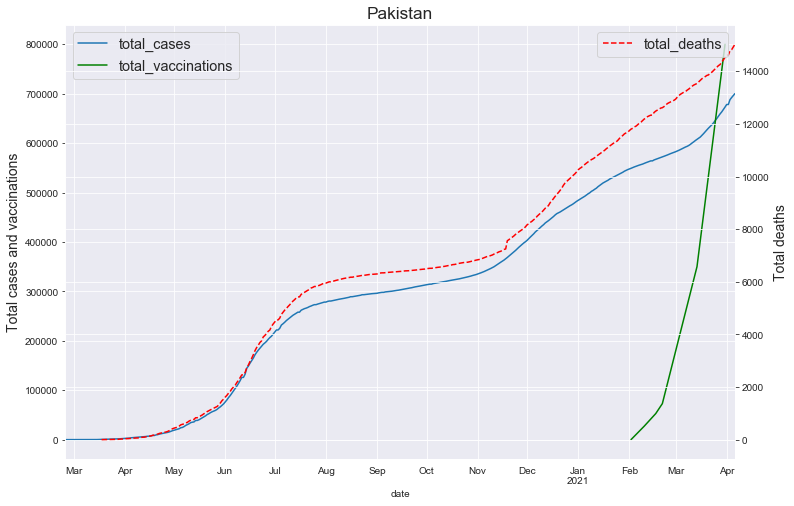

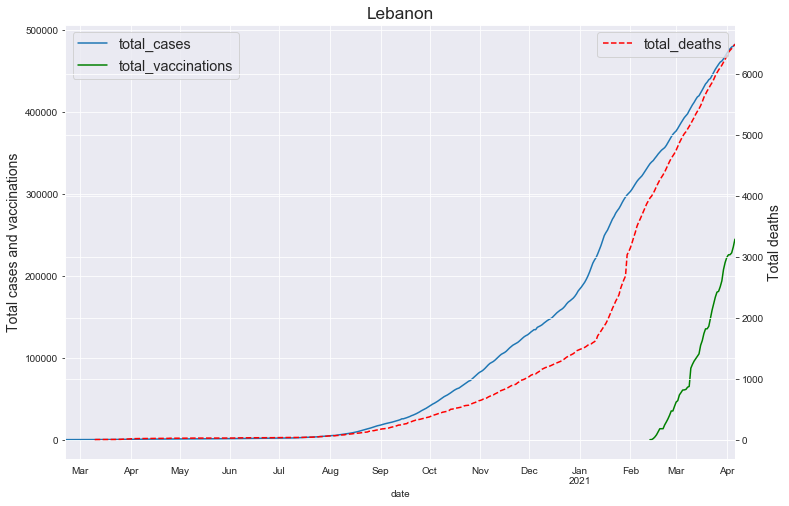

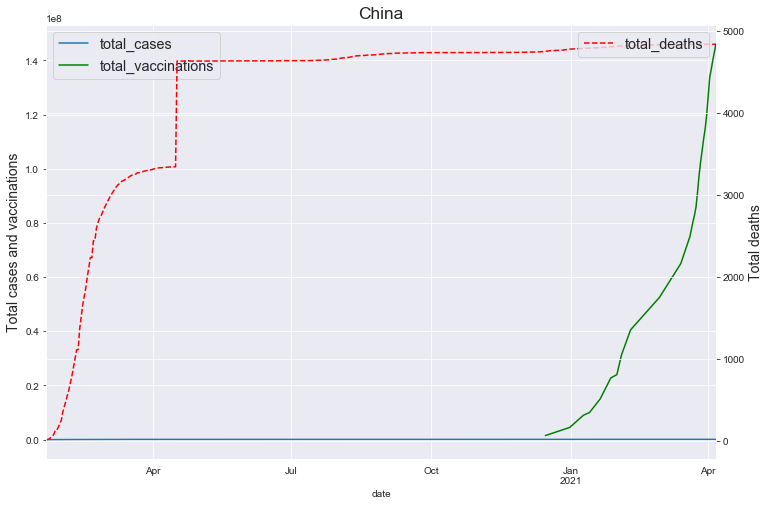

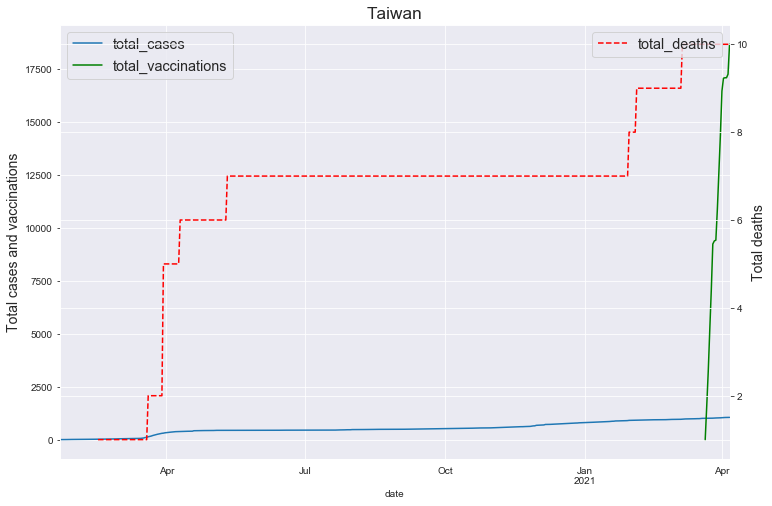

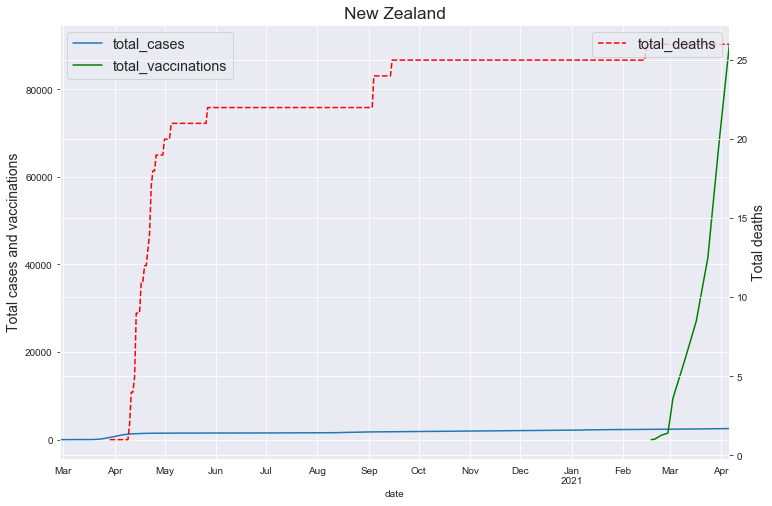

In [577]:
vtplot('Canada')
vtplot('United Kingdom')
vtplot('Japan')
vtplot('South Korea')
vtplot('India')
vtplot('Italy')
vtplot('United States')
vtplot('Pakistan')
vtplot('Lebanon')
vtplot('China')
vtplot('Taiwan')
vtplot('New Zealand')

## Chloropleth visualizations
- useful package plotly.express to use world maps to visualize the variables

In [37]:
odf_nocontinent = odf[-odf.location.isin(['World','European Union','North America','South America','Asia','Africa','Europe','Oceania'])] # Removing Continents

In [38]:
#only take the max of each grouping
odf_totalcases = odf_nocontinent.groupby(odf_nocontinent['location']).agg(['max'])
odf_totalcases.columns = odf_totalcases.columns.droplevel(1)

## total_cases and total_deaths
- target variables for our visual analysis
    - note that total_deaths and cases _per million will also be taken into account
- the top 3 countries have very wide variance

In [40]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='total_cases',
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## total_deaths 
- similar to total_cases

In [41]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='total_deaths',
                    hover_name=odf_totalcases.index, 
                    hover_data=['population_density','stringency_index','human_development_index'],
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## Median Age
- note: aged_65_older and aged_70_older columns were removed as they were too correlated with median age
- median age is an important factor in determining how fatal the virus will be on populations
- generally, populations with higher median age are at risk for a higher crude mortality, ie. Italy, Spain, Portugal
- however, countries like Japan, even while having one of the highest median ages do not have the total deaths some other countries have at lower median ages

In [567]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color=odf_totalcases.median_age,
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.diverging.curl,
                    color_continuous_midpoint=20)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [569]:
odf_ma40 = odf[odf.median_age>40]
odf_ma20 = odf[odf.median_age<20]

top5_ma = odf_totalcases.sort_values(by='median_age', ascending=False).head(5).index.tolist()
bot5_ma = odf_totalcases.sort_values(by='median_age', ascending=True).head(5).index.tolist()

Text(0.5, 0.98, 'Top 5 and Bottom 5 in Median Age')

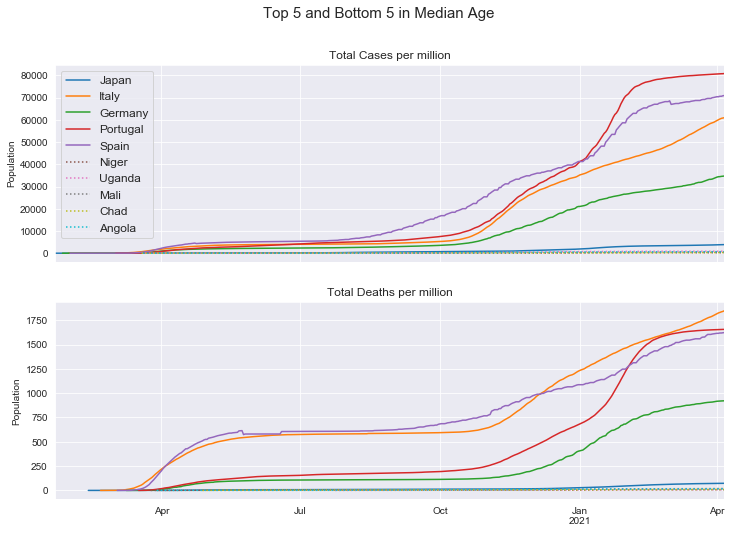

In [575]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)

for i in top5_ma:
    for x, y in enumerate([odf[odf.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-')
for i in bot5_ma:
    for x, y in enumerate([odf[odf.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='dotted')
        
for i in top5_ma:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-')
for i in bot5_ma:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='dotted')

ax[0].set(xlabel = '', ylabel='Population', title='Total Cases per million')
#ax[0].set_title('Total Cases per million',fontsize=20)
ax[0].legend(top5_ma+bot5_ma, fontsize='large')
ax[1].set(xlabel = '', ylabel='Population', title='Total Deaths per million')  
#ax[1].set_title('Total Deaths per million',fontsize=20)
fig.suptitle('Top 5 and Bottom 5 in Median Age', fontsize=15)



- Even though japan has the highest median age, they are among the lowest deaths in their population cohort 
- Possible reasons

## Stringency Index
- composite index measuring how strict a region is with lockdowns
- takes into account stay-at-home-orders, public, private closures and travel bans

In [581]:
zf = pd.DataFrame(df.groupby(by=['iso_code', 'location']).agg(['mean']))
zf.reset_index(inplace=True)
zf.columns = zf.columns.droplevel(1)

In [791]:
fig = px.choropleth(zf, locations='iso_code',
                    color='stringency_index',
                    hover_name='location', 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [826]:
top5_si = zf.sort_values(by='stringency_index', ascending=False).head(10).location.tolist()
bot5_si = zf.sort_values(by='stringency_index', ascending=True).head(10).location.tolist()

In [827]:
top5_si

['Honduras',
 'Eritrea',
 'Venezuela',
 'Libya',
 'Bangladesh',
 'Palestine',
 'Myanmar',
 'Azerbaijan',
 'Panama',
 'Colombia']

Text(0.5, 0.98, 'Top 10 (solid lines) and Bottom 10 (dashed) in Stringency Index')

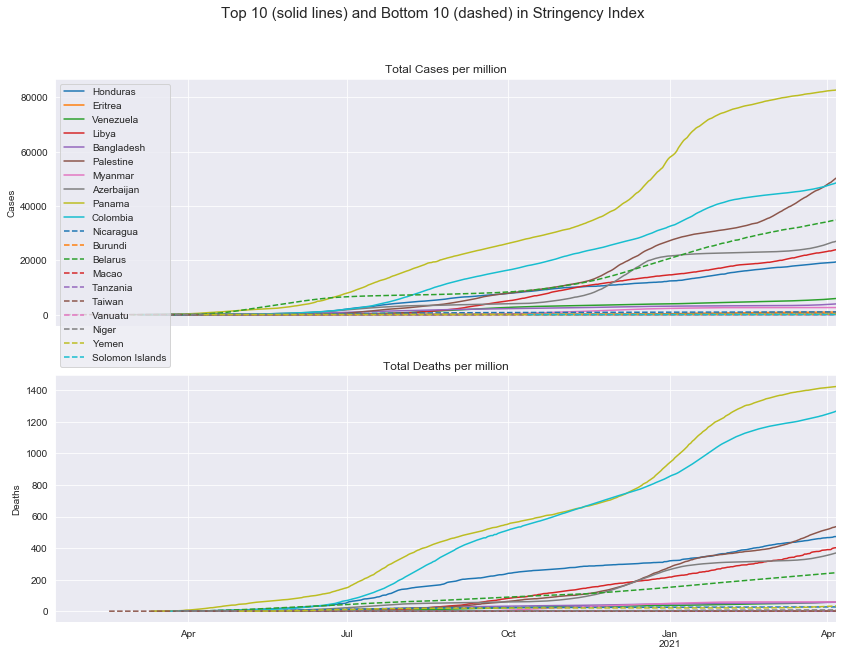

In [935]:
fig, ax = plt.subplots(2,1,figsize=(14,10), sharex=True)

for i in top5_si:
    for x, y in enumerate([odf[odf.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='-')
for i in bot5_si:
    for x, y in enumerate([odf[odf.location==i].total_cases_per_million]):
        y.plot(ax=ax[0], linestyle='--')
        
for i in top5_si:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-')
        #ax[1].annotate(i, xy=(odf.index.max(), odf[odf.location==i].total_deaths_per_million.max()))
for i in bot5_si:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='--')
        #ax[1].annotate(i, xy=(odf.index.max(), odf[odf.location==i].total_deaths_per_million.max()))

ax[0].set(xlabel = '', ylabel='Cases', title='Total Cases per million')
#ax[0].set_title('Total Cases per million',fontsize=20)
ax[0].legend(top5_si+bot5_si, fontsize='medium')
ax[1].set(xlabel = '', ylabel='Deaths', title='Total Deaths per million')  
#ax[1].set_title('Total Deaths per million',fontsize=20)
fig.suptitle('Top 10 (solid lines) and Bottom 10 (dashed) in Stringency Index', fontsize=15)

- There does not seem to be a positive correlation between higher stringency and lower cases/deaths
- It is important to note stringency is a measure of the government actions taken, not of the peoples' adherence to it.

In [588]:
list_pd = odf_totalcases.sort_values('population_density', ascending=False).head(5).index.tolist()

In [589]:
odf2 = odf_totalcases.copy()
odf2.drop(labels=list_pd, axis=0, inplace=True)

In [586]:
zf.sort_values(by='stringency_index', ascending=False).head(10)[['location','stringency_index','total_deaths_per_million','total_cases_per_million']]

location  stringency_index  total_deaths_per_million  \
139        Nicaragua         13.643794                 17.963487   
12           Burundi         14.930730                  0.135758   
21           Belarus         19.200800                100.273481   
116            Macao         23.150000                       NaN   
198         Tanzania         23.420622                  0.328823   
197           Taiwan         24.529170                  0.279865   
208          Vanuatu         24.716531                       NaN   
137            Niger         30.705209                  3.604743   
210            Yemen         33.822936                 17.003345   
173  Solomon Islands         36.881235                       NaN   

     total_cases_per_million  
139               613.345917  
12                 63.936013  
21              12120.432926  
116                      NaN  
198                 7.704362  
197                22.364780  
208                 4.575797  
137                82.958042  
210                58.673381  
173                22.759446

In [53]:
zf.sort_values(by='stringency_index', ascending=True).head(10)[['location','stringency_index','total_deaths_per_million','total_cases_per_million']].dropna()

location  stringency_index  total_deaths_per_million  \
139  Nicaragua         13.643794                 17.963487   
12     Burundi         14.930730                  0.135758   
21     Belarus         19.200800                100.273481   
198   Tanzania         23.420622                  0.328823   
197     Taiwan         24.529170                  0.279865   
137      Niger         30.705209                  3.604743   
210      Yemen         33.822936                 17.003345   

     total_cases_per_million  
139               613.345917  
12                 63.936013  
21              12120.432926  
198                 7.704362  
197                22.364780  
137                82.958042  
210                58.673381

In [590]:
fig = px.choropleth(odf2, locations='iso_code',
                    color='population_density',
                    hover_name=odf2.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## Hospital beds per thousand

In [751]:
hbdf = odf_totalcases.sort_values(by='hospital_beds_per_thousand', ascending=False)[['hospital_beds_per_thousand','total_deaths_per_million','median_age']].dropna()

In [752]:
hbdf.reset_index(inplace=True)


In [753]:
hbdf.head(10)

location  hospital_beds_per_thousand  total_deaths_per_million  \
0        Japan                      13.050                    73.144   
1  South Korea                      12.270                    34.251   
2      Belarus                      11.000                   243.827   
3      Ukraine                       8.800                   838.986   
4       Russia                       8.050                   681.340   
5      Germany                       8.000                   921.955   
6     Bulgaria                       7.454                  1984.041   
7      Austria                       7.370                  1056.693   
8      Hungary                       7.020                  2287.495   
9     Mongolia                       7.000                     3.965   

   median_age  
0        48.2  
1        43.4  
2        40.3  
3        41.4  
4        39.6  
5        46.6  
6        44.7  
7        44.4  
8        43.4  
9        28.6

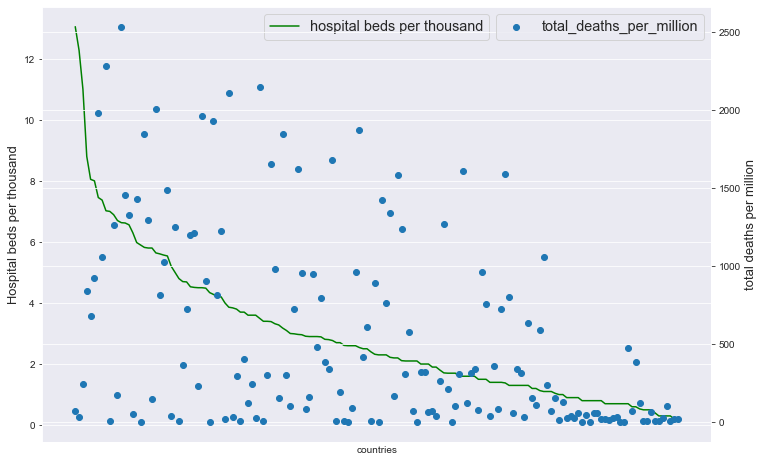

In [757]:
fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_xlabel('countries')
host.set_ylabel('Hospital beds per thousand', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(hbdf.hospital_beds_per_thousand.values), color='g')
p2 = par1.scatter(x=np.arange(0,len(hbdf)),y=np.array(hbdf.total_deaths_per_million.values))
host.legend(labels=['hospital beds per thousand'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths_per_million'], loc='upper right', fontsize='x-large')


In [936]:
mdf = hbdf[hbdf.median_age>42]

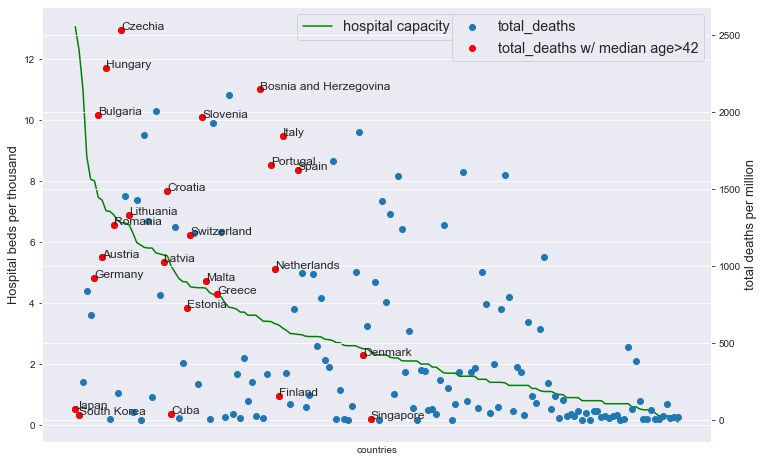

In [937]:

fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_xlabel('countries')
host.set_ylabel('Hospital beds per thousand', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(hbdf.hospital_beds_per_thousand.values), color='g')
p2 = par1.scatter(x=np.arange(0,len(hbdf)),y=np.array(hbdf.total_deaths_per_million.values))
p22 = par1.scatter(x=np.array(mdf.index.tolist()), y=np.array(mdf.total_deaths_per_million.values), color='r')
host.legend(labels=['hospital capacity'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths','total_deaths w/ median age>42'], loc='upper right', fontsize='x-large')

for i in range(mdf.shape[0]):
    plt.annotate(mdf.location.tolist()[i], (mdf.index.tolist()[i], mdf.total_deaths_per_million.tolist()[i]),fontsize=12)

- Counterintuitively, the trend shows that less hospital capacity is correlated somewhat to a lower total death count. This means mean there are other factors to be considered.
- median age and hospital beds per thousand are moderately positively correlated with a pearson coefficient of 0.66
 

In [761]:
fsdf = odf_totalcases.sort_values(by='female_smokers', ascending=False)[['hospital_beds_per_thousand','total_deaths_per_million','male_smokers','female_smokers','median_age']].dropna()

In [762]:
fsdf.reset_index(inplace=True)

In [776]:
mddf = fsdf[fsdf.median_age>42]

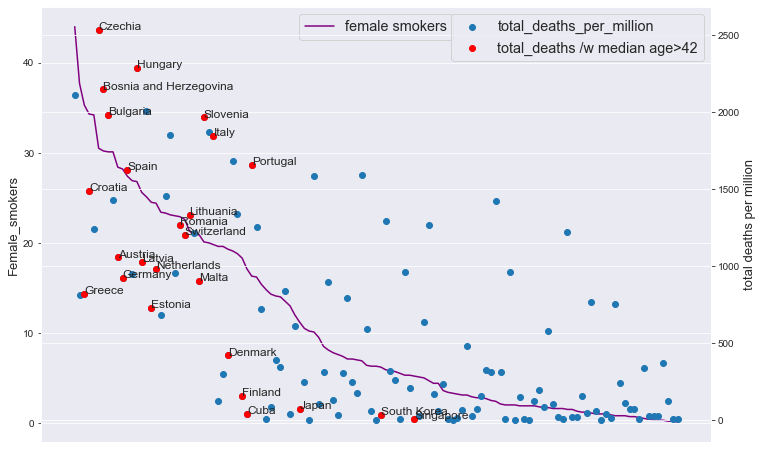

In [778]:

fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_ylabel('Female_smokers', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(fsdf.female_smokers.values), color='purple')
p2 = par1.scatter(x=np.arange(0,len(fsdf)),y=np.array(fsdf.total_deaths_per_million.values))
p22 = par1.scatter(x=np.array(mddf.index.tolist()), y=np.array(mddf.total_deaths_per_million.values), color='r')
host.legend(labels=['female smokers'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths_per_million', 'total_deaths /w median age>42'], loc='upper right', fontsize='x-large')


for i in range(mddf.shape[0]):
    plt.annotate(mddf.location.tolist()[i], (mddf.index.tolist()[i], mddf.total_deaths_per_million.tolist()[i]),fontsize=12)


- female smoker correlation is very strong
- pearson correlation femalesmokers vs total_deaths_per_million = 0.69 which is a strong positive correlation


In [780]:
fsdf.corr(method='pearson')

hospital_beds_per_thousand  \
hospital_beds_per_thousand                    1.000000   
total_deaths_per_million                      0.344949   
male_smokers                                  0.379599   
female_smokers                                0.491281   
median_age                                    0.660043   

                            total_deaths_per_million  male_smokers  \
hospital_beds_per_thousand                  0.344949      0.379599   
total_deaths_per_million                    1.000000      0.089060   
male_smokers                                0.089060      1.000000   
female_smokers                              0.699401      0.216911   
median_age                                  0.589237      0.252351   

                            female_smokers  median_age  
hospital_beds_per_thousand        0.491281    0.660043  
total_deaths_per_million          0.699401    0.589237  
male_smokers                      0.216911    0.252351  
female_smokers                    1.000000    0.692822  
median_age                        0.692822    1.000000

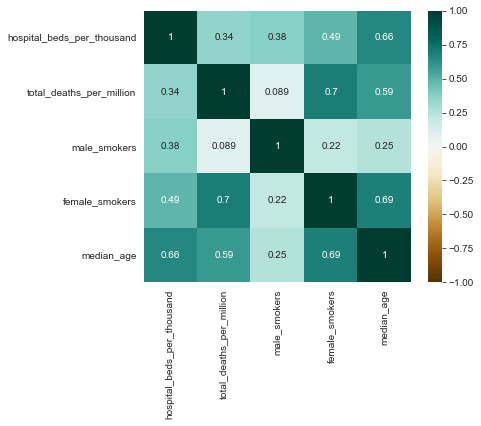

In [786]:
plt.figure(figsize=(6,5))
sns.heatmap(fsdf.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [765]:
msdf = odf_totalcases.sort_values(by='male_smokers', ascending=False)[['hospital_beds_per_thousand','total_deaths_per_million','male_smokers','female_smokers','gdp_per_capita']].dropna()

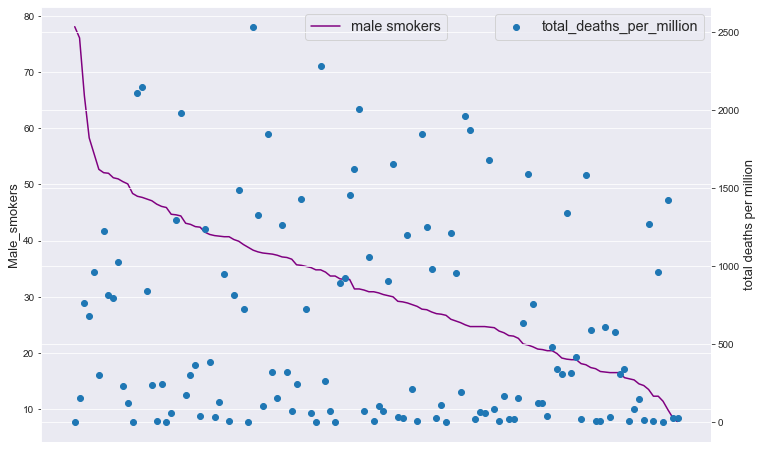

In [766]:
fig, host = plt.subplots(figsize=(12,8))
par1 = host.twinx()

host.set_xlim(auto=True)
host.set_xticks([])
host.set_ylim(auto=True)
par1.set_ylim(auto=True)

host.set_ylabel('Male_smokers', fontsize=13)
par1.set_ylabel('total deaths per million', fontsize=13)
p1 = host.plot(np.array(msdf.male_smokers.values), color='purple')
p2 = par1.scatter(x=np.arange(0,len(msdf)),y=np.array(msdf.total_deaths_per_million.values))
host.legend(labels=['male smokers'], loc='upper center', fontsize='x-large')
par1.legend(labels=['total_deaths_per_million'], loc='upper right', fontsize='x-large')

In [ ]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='hospital_beds_per_thousand',
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [ ]:
odf_totalcases[odf_totalcases.total_cases_per_million.between(2000,10000)][['total_deaths_per_million','total_cases_per_million','population','population_density','hospital_beds_per_thousand']].sort_values(by='total_deaths_per_million').dropna()

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
hbpt = odf_totalcases[odf_totalcases.population.between(100000000,200000000)][['total_deaths_per_million','total_cases_per_million','population','population_density','hospital_beds_per_thousand']].sort_values(by='total_deaths_per_million')

In [ ]:
hbpt.sort_values(by='hospital_beds_per_thousand', ascending=False)

In [ ]:
odf_hb7 = odf[odf.hospital_beds_per_thousand>6]
odf_hb6 = odf[odf.hospital_beds_per_thousand<6]

top5_hbpt = odf_totalcases.sort_values(by='hospital_beds_per_thousand', ascending=False).head(5).index.tolist()
bot5_hbpt = odf_totalcases.sort_values(by='hospital_beds_per_thousand', ascending=True).head(5).index.tolist()

In [ ]:
bot5_hbpt

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

for i in top5_hbpt:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[0], linestyle='-')
for i in bot5_hbpt:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[0], linestyle='dotted')

for i in top5_hbpt:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='-')
for i in bot5_hbpt:
    for x, y in enumerate([odf[odf.location==i].total_deaths_per_million]):
        y.plot(ax=ax[1], linestyle='dotted')

ax[0].set(xlabel = '', ylabel='Population', title = 'Total cases per million')  
ax[0].legend(top5_hbpt+bot5_hbpt, fontsize='large')
ax[1].set(xlabel = '', ylabel='Population', title = 'Total deaths per million')  



In [ ]:
fig = px.choropleth(odf_totalcases, locations='iso_code',
                    color='extreme_poverty',
                    hover_name=odf_totalcases.index, 
                    color_continuous_scale=px.colors.sequential.deep)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

# Correlations

In [841]:
#Removing redundant columns
#some columns are removed due to multicollinearity
OWIDdf = OWIDdf.drop(columns=['aged_65_older','aged_70_older','iso_code','continent'])

In [842]:
odft=odf_totalcases.copy()
list_ts = [col for col in odft.columns if 'new' in col or 'total' in col or 'people' in col]
odft = odft.drop(columns=['aged_65_older','aged_70_older','iso_code','continent','reproduction_rate','positive_rate','tests_per_case']+list_ts)

In [843]:
odft.corr()

stringency_index  population  population_density  \
stringency_index                    1.000000    0.057438           -0.208643   
population                          0.057438    1.000000           -0.028982   
population_density                 -0.208643   -0.028982            1.000000   
median_age                          0.006243    0.036058            0.149113   
gdp_per_capita                     -0.129961   -0.052685            0.409232   
extreme_poverty                    -0.264952   -0.039960           -0.029067   
cardiovasc_death_rate               0.032822   -0.004860           -0.175718   
diabetes_prevalence                 0.105290    0.029992            0.020060   
female_smokers                     -0.056695   -0.119315           -0.062020   
male_smokers                        0.082662    0.028076            0.000418   
handwashing_facilities              0.420384    0.039389            0.102984   
hospital_beds_per_thousand         -0.077334   -0.036832            0.315258   
life_expectancy                     0.008447   -0.020030            0.235196   
human_development_index             0.088564   -0.015316            0.180556   
crude_mortality                     0.121181   -0.064045           -0.000176   

                            median_age  gdp_per_capita  extreme_poverty  \
stringency_index              0.006243       -0.129961        -0.264952   
population                    0.036058       -0.052685        -0.039960   
population_density            0.149113        0.409232        -0.029067   
median_age                    1.000000        0.639389        -0.697290   
gdp_per_capita                0.639389        1.000000        -0.507000   
extreme_poverty              -0.697290       -0.507000         1.000000   
cardiovasc_death_rate        -0.340101       -0.476683         0.189471   
diabetes_prevalence           0.155542        0.182956        -0.401898   
female_smokers                0.671911        0.352421        -0.411692   
male_smokers                  0.198093       -0.088163        -0.192223   
handwashing_facilities        0.785879        0.647415        -0.751043   
hospital_beds_per_thousand    0.663296        0.299505        -0.443556   
life_expectancy               0.846447        0.680991        -0.752270   
human_development_index       0.899684        0.755712        -0.777256   
crude_mortality               0.605296        0.312048        -0.463878   

                            cardiovasc_death_rate  diabetes_prevalence  \
stringency_index                         0.032822             0.105290   
population                              -0.004860             0.029992   
population_density                      -0.175718             0.020060   
median_age                              -0.340101             0.155542   
gdp_per_capita                          -0.476683             0.182956   
extreme_poverty                          0.189471            -0.401898   
cardiovasc_death_rate                    1.000000             0.130928   
diabetes_prevalence                      0.130928             1.000000   
female_smokers                          -0.171931            -0.054708   
male_smokers                             0.417471             0.169587   
handwashing_facilities                  -0.039956             0.473175   
hospital_beds_per_thousand               0.015024            -0.073993   
life_expectancy                         -0.466589             0.258217   
human_development_index                 -0.425665             0.214335   
crude_mortality                         -0.208352            -0.020385   

                            female_smokers  male_smokers  \
stringency_index                 -0.056695      0.082662   
population                       -0.119315      0.028076   
population_density               -0.062020      0.000418   
median_age                        0.671911      0.198093   
gdp_per_capita                    0.352421     -0.088163   
e

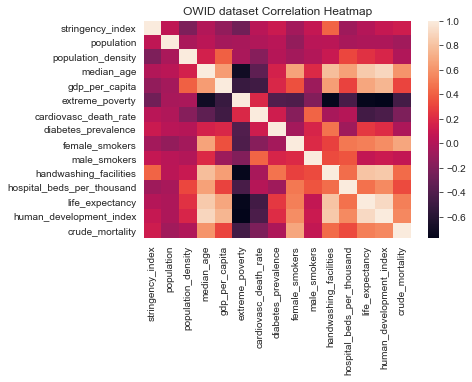

In [844]:
save = sns.heatmap(odft.corr()).set_title('OWID dataset Correlation Heatmap')

#save.figure.savefig('heatmap.png')

Text(0.5, 1, 'Features correlating with total_cases')

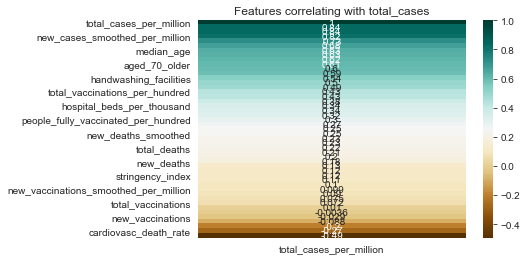

In [845]:
sns.heatmap(odf_totalcases.corr()[['total_cases_per_million']].sort_values(by='total_cases_per_million', ascending=False),
            annot=True, cmap='BrBG').set_title('Features correlating with total_cases')

Text(0.5, 1, 'Features correlating with total_deaths')

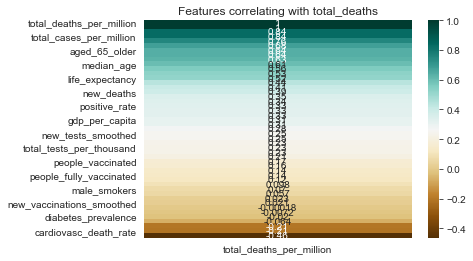

In [846]:
dhmp = sns.heatmap(odf_totalcases.corr()[['total_deaths_per_million']].sort_values(by='total_deaths_per_million', ascending=False), annot=True, cmap='BrBG')
dhmp.set_title('Features correlating with total_deaths')

In [ ]:
nowiddfn = odf.select_dtypes(include='float64')
#ppdf = sns.pairplot(nowiddfn.sample(1000))
#ppdf.savefig("pairplotowid.png")

Some of the target variables to consider: reproduction_rate, total_cases_per_million, total_deaths_per_million.
Normally we would also consider crude mortality rate or case-fatality rate as well. However, confirmed cases is often underreported AND undertested and as such may be harder to evaluate accurately. It is important to consider that the data being robust and accurate relies heavily on the nation's testing capacity. 

Remember that the reproduction rate (R) describes the trajectory of the virus. A value of R = 1 means the amount of new infections and new recoveries are equal; meaning the virus numbers will stagnate. A value of 6.74 means the number of infected is sharply increasing and may lead in a big spike of infections and deaths, depending on government mitigation strategy.

In [847]:
print(OWIDdf.reproduction_rate.max())
odf[odf.reproduction_rate==OWIDdf.reproduction_rate.max()]

5.71


iso_code continent     location  total_cases  new_cases  \
date                                                                 
2020-02-21      KOR      Asia  South Korea        204.0      100.0   

            new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
date                                                                            
2020-02-21              25.143           2.0         1.0                0.286   

            total_cases_per_million  ...  gdp_per_capita  extreme_poverty  \
date                                 ...                                    
2020-02-21                    3.979  ...       35938.374              0.2   

            cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
date                                                                     
2020-02-21                 85.998                  6.8             6.2   

            male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
date                                                                           
2020-02-21          40.9                     NaN                       12.27   

            life_expectancy  human_development_index  
date                                                  
2020-02-21            83.03                    0.916  

[1 rows x 50 columns]

# Visualizations

In [882]:
odf1 = df.groupby(df['location']).agg(['max'])
odf1.columns = odf1.columns.droplevel(1)
odf1.reset_index(level=0, inplace=True)

In [884]:
odf1 = odf1[odf1.population.notna()]

odf1 = odf1[odf1.total_cases.notna()]

odf1 = odf1[odf1.population_density.notna()]

odf1 = odf1[odf1.human_development_index.notna()]

odf1 = odf1[odf1.gdp_per_capita.notna()]

odf1 = odf1[odf1.total_deaths_per_million.notna()]

odf1 = odf1[odf1.life_expectancy.notna()]

In [856]:
odf1 = odf1[-odf1.location.isin(['World','European Union','North America','South America','Asia','Africa','Europe','Oceania'])]

In [885]:
odfpx = odf1.sort_values(by='population_density', ascending=False).head(10)

In [925]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='gdp_per_capita',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs gdp_per_capita')

In [950]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='total_deaths_per_million',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs dpm')

In [951]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='median_age',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs dpm')

- Countries with lower life expectancy, HDI and GDP tend to fare better against COVID deaths, which is somewhat counter intuitive
- Better economy = more healthcare services, so why does the data show the opposite?
- GDP, HDI lead to better life expectancy, which leads to higher median age
    - effectively a larger proportion of your population is at risk

In [929]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='diabetes_prevalence',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs diabetes')

In [930]:
px.scatter(odf1, x='life_expectancy',y='human_development_index', size='cardiovasc_death_rate',
           color ='continent', hover_name='location',
           title='HDI vs Life_expectancy vs cardiovasc')

In [931]:

px.scatter(odf1, x='cardiovasc_death_rate',y='diabetes_prevalence', size='total_deaths_per_million',
           color ='continent', hover_name='location',
           title='cardiovasc vs diabetes vs total_deaths_per_million')

In [889]:
px.scatter(odf1, x='male_smokers',y='female_smokers', size='total_deaths_per_million',
           color ='continent', hover_name='location',
           title='msmoke vs fsmoke vs total_deaths_per_million')

- very strong correlation between female smokers and total dpm

In [890]:
odf1 = odf1[odf1.median_age.notna()]

In [891]:
odf1.sort_values(by='population_density', ascending=False)[['location','population_density']]

location  population_density
174   Singapore            7915.731
15      Bahrain            1935.907
120    Maldives            1454.433
122       Malta            1454.037
16   Bangladesh            1265.036
..          ...                 ...
186    Suriname               3.612
88      Iceland               3.404
11    Australia               3.202
136     Namibia               3.078
130    Mongolia               1.980

[171 rows x 2 columns]

In [934]:

px.scatter(odf1, x='population',y='population_density', size='total_cases_per_million',
           color ='continent', hover_name='location',
           title='population density and cpm')

In [893]:
odfdt_vis = odf1[odf1['handwashing_facilities'].notna()]

In [897]:
px.scatter(odfdt_vis,x='total_deaths_per_million',y='handwashing_facilities',
           color='continent', hover_data=['location'],
           title='Handwashing facilities and crude mortality')

The data shows that having more handwashing facilities doesn't necessarily indicate better COVID19 outcomes

In [904]:
px.scatter(odfdt_vis,x='total_deaths_per_million',y='median_age',
           color='location', hover_data=['location'],
           title='median age and dpm')

- Countries with higher median age are typically hit harder

# Data Mining experimenting

## Random Forest Regressor
- looking at Feature importances and permutation importances
- preprocessing the dataframe to remove multicollinearity between time series variables

In [57]:
list_nocol = [col for col in df.columns if 'new' in col or 'per' in col or 'people' in col or 'aged' in col or 'units' in col]

## RF Importances 

In [116]:
def RFimportances(y, X):
    #Train test split
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
    
    #Imputing median in NA
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp = imp.fit(train_X)
    train_X = imp.transform(train_X)

    valimp = SimpleImputer(missing_values=np.nan, strategy='median')
    valimp = valimp.fit(val_X)
    val_X = valimp.transform(val_X)

    val_y = val_y.fillna(val_y.median())
    train_y = train_y.fillna(train_y.median())
    
    #Model fitting
    clf = RandomForestRegressor(n_estimators=100, bootstrap = True, random_state = 1)
    clf = clf.fit(train_X, train_y)
    
    #Model evaluation
    print("Model Evaluation:")
    print('R^2 training set: {:.2f} \nR^2 val set: {:.2f}'.format(clf.score(train_X, train_y),clf.score(val_X, val_y)))
    val_pred = clf.predict(val_X)
    val_mae = mean_absolute_error(val_pred, val_y)
    print("validation MAE: {:,.0f}\n".format(val_mae))

    
    #Feature Importances
    print("Feature Importances")
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    for f in range (train_X.shape[1]):
        featurelist = []
        featurelist.append(X.columns[indices[f]])
        print(f"{X.columns.get_loc(X.columns[indices[f]])}\t"
              f"{X.columns[indices[f]]} "
              f"{importances[indices[f]]:.4f}")

    plt.figure(figsize=(12,8))
    plt.title("Feature importances")
    plt.bar(d, importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(train_X.shape[1]), indices)
    plt.xlim([-1, train_X.shape[1]])
    plt.show()
    
    #Permutation importances
    print('Permutation Importances')
    a,b,c = [],[],[]
    r = permutation_importance(clf, val_X, val_y)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            a.append(r.importances_mean[i])
            b.append(str(i+1))
            c.append(r.importances_std[i])
            print(f"{i+1} \t"
                  f"{X.columns[i]:<8} \t"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

    plt.figure(figsize=(12,8))
    plt.title("Permutation importances")
    plt.bar(b, a, yerr=c, color="r", align="center")
    plt.xticks(b)
    plt.show()

## Target variable: total_deaths
- total deaths is a good target variable

In [112]:
y = df.total_deaths
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

Model Evaluation:
R^2 training set: 0.85 
R^2 val set: 0.74
validation MAE: 5,707

Feature Importances
13	total_vaccinations 0.6377
6	life_expectancy 0.1074
9	population_density 0.0929
12	total_tests 0.0576
11	stringency_index 0.0253
0	cardiovasc_death_rate 0.0213
2	extreme_poverty 0.0181
1	diabetes_prevalence 0.0108
5	human_development_index 0.0090
3	female_smokers 0.0069
7	male_smokers 0.0053
10	reproduction_rate 0.0049
8	median_age 0.0025
4	handwashing_facilities 0.0007


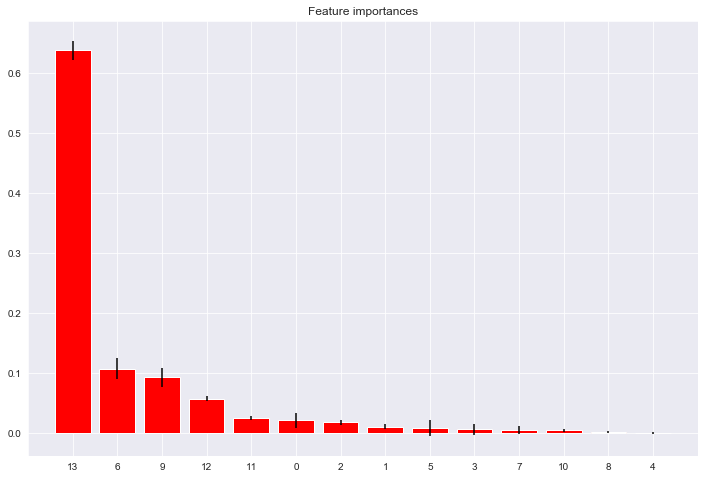

Permutation Importances
14 	total_vaccinations 	0.936 +/- 0.028
10 	population_density 	0.209 +/- 0.018
7 	life_expectancy 	0.181 +/- 0.008
13 	total_tests 	0.118 +/- 0.003
3 	extreme_poverty 	0.067 +/- 0.004
12 	stringency_index 	0.044 +/- 0.003
1 	cardiovasc_death_rate 	0.024 +/- 0.004
2 	diabetes_prevalence 	0.019 +/- 0.001
9 	median_age 	0.012 +/- 0.001
11 	reproduction_rate 	0.010 +/- 0.001
6 	human_development_index 	0.005 +/- 0.002
4 	female_smokers 	0.004 +/- 0.000
8 	male_smokers 	0.001 +/- 0.001
5 	handwashing_facilities 	0.001 +/- 0.000


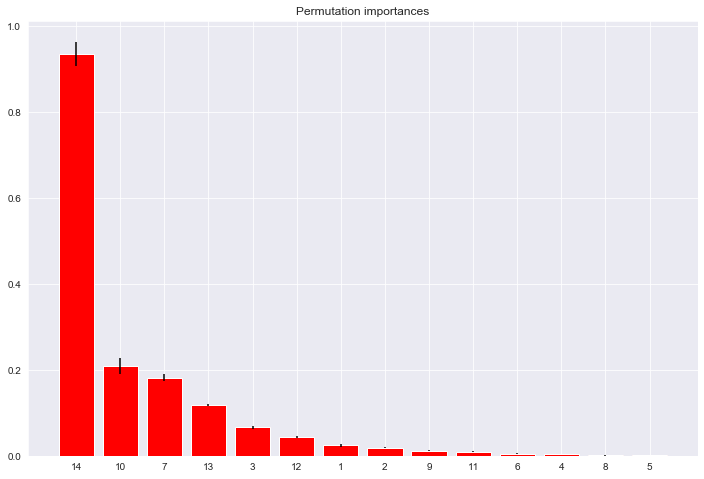

In [117]:
RFimportances(y, X)

## Target variable: total_deaths_per_million
- may be better target than simply total_deaths
- normalized for population differences
- population and total_deaths must be removed to prevent multicollinearity

In [128]:
y = df.total_deaths_per_million
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

Model Evaluation:
R^2 training set: 0.98 
R^2 val set: -3.31
validation MAE: 468

Feature Importances
13	total_vaccinations 0.2724
3	female_smokers 0.1199
12	total_tests 0.1049
11	stringency_index 0.0928
5	human_development_index 0.0757
6	life_expectancy 0.0621
9	population_density 0.0559
2	extreme_poverty 0.0505
10	reproduction_rate 0.0455
7	male_smokers 0.0398
0	cardiovasc_death_rate 0.0299
1	diabetes_prevalence 0.0240
8	median_age 0.0173
4	handwashing_facilities 0.0092


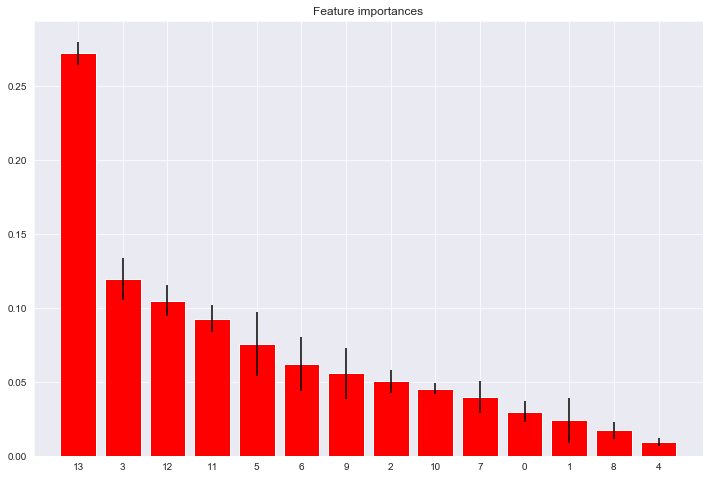

Permutation Importances
4 	female_smokers 	0.506 +/- 0.037
6 	human_development_index 	0.291 +/- 0.003
14 	total_vaccinations 	0.072 +/- 0.013
13 	total_tests 	0.029 +/- 0.000
7 	life_expectancy 	0.025 +/- 0.002
11 	reproduction_rate 	0.009 +/- 0.003


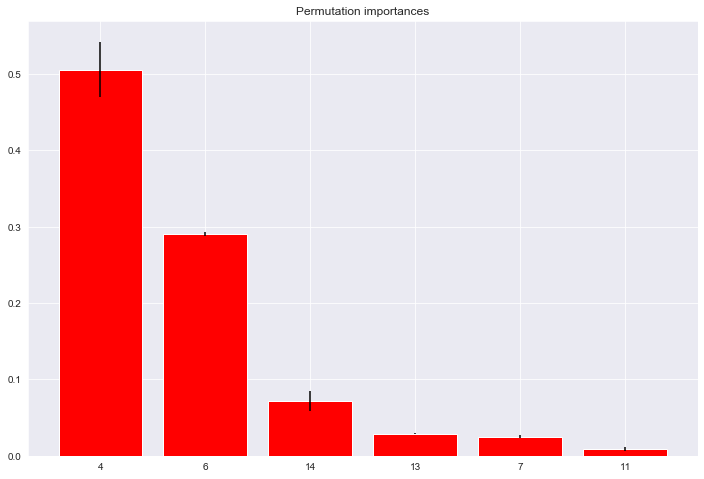

In [129]:
RFimportances(y, X)
#model evaluation shows this is a weak model and subject to overfitting

## Target variable: total_cases
- insight how the virus spread

In [130]:
y = df.total_cases
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

Model Evaluation:
R^2 training set: 0.89 
R^2 val set: 0.79
validation MAE: 192,535

Feature Importances
13	total_vaccinations 0.6767
9	population_density 0.1032
12	total_tests 0.0827
6	life_expectancy 0.0594
5	human_development_index 0.0252
0	cardiovasc_death_rate 0.0133
11	stringency_index 0.0128
7	male_smokers 0.0112
2	extreme_poverty 0.0073
10	reproduction_rate 0.0026
3	female_smokers 0.0019
8	median_age 0.0018
1	diabetes_prevalence 0.0017
4	handwashing_facilities 0.0003


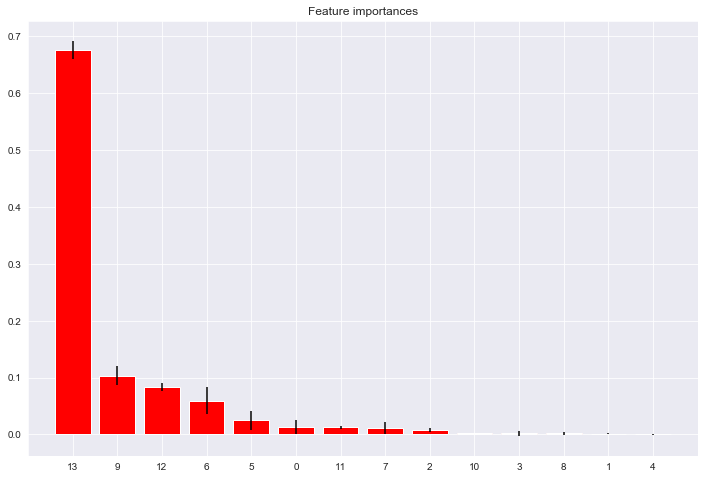

Permutation Importances
14 	total_vaccinations 	1.109 +/- 0.027
10 	population_density 	0.307 +/- 0.021
13 	total_tests 	0.232 +/- 0.004
7 	life_expectancy 	0.076 +/- 0.002
3 	extreme_poverty 	0.074 +/- 0.002
6 	human_development_index 	0.065 +/- 0.002
12 	stringency_index 	0.020 +/- 0.001
1 	cardiovasc_death_rate 	0.011 +/- 0.002
8 	male_smokers 	0.006 +/- 0.002
11 	reproduction_rate 	0.005 +/- 0.001
9 	median_age 	0.002 +/- 0.000
2 	diabetes_prevalence 	0.001 +/- 0.000
5 	handwashing_facilities 	0.000 +/- 0.000


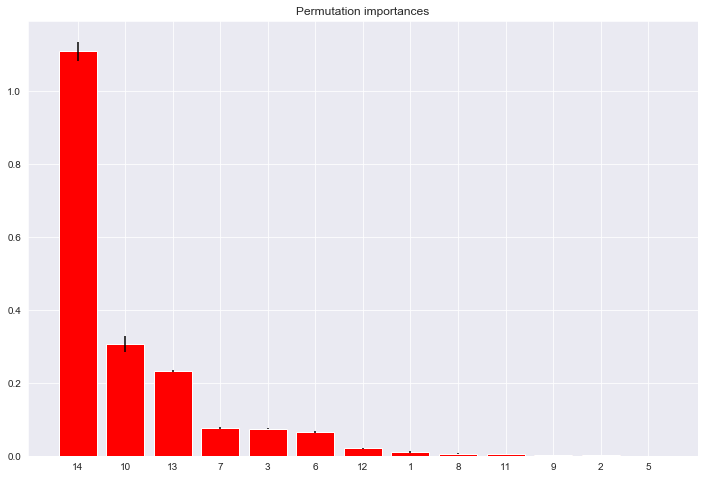

In [131]:
RFimportances(y, X)

# Multiple Regression 

In [139]:
y = df.total_deaths
X = df[df.columns.difference(list_nocol+['iso_code','location','continent','crude_mortality','total_deaths','positive_rate','population','total_cases','tests_units'])] 

In [140]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [141]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(train_X)
train_X = imp.transform(train_X)

valimp = SimpleImputer(missing_values=np.nan, strategy='median')
valimp = valimp.fit(val_X)
val_X = valimp.transform(val_X)
train_y = train_y.fillna(train_y.median())

In [142]:
model = sm.OLS(train_y, train_X).fit()

In [143]:
predictions = model.predict(train_X)

In [144]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           total_deaths   R-squared (uncentered):                   0.409
Model:                            OLS   Adj. R-squared (uncentered):              0.408
Method:                 Least Squares   F-statistic:                              2938.
Date:                Wed, 07 Apr 2021   Prob (F-statistic):                        0.00
Time:                        16:05:45   Log-Likelihood:                     -7.2498e+05
No. Observations:               59579   AIC:                                  1.450e+06
Df Residuals:                   59565   BIC:                                  1.450e+06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -9.8433      1.944     -5.065      0.000     -13.653      -6.034
x2          -682.6995     56.925    -11.993      0.000    -794.273    -571.126
x3          -294.0985     16.539    -17.782      0.000    -326.515    -261.682
x4          -179.0915     29.121     -6.150      0.000    -236.169    -122.014
x5           -84.4318     12.084     -6.987      0.000    -108.117     -60.746
x6          7707.7417   3784.268      2.037      0.042     290.562    1.51e+04
x7           404.6006     37.774     10.711      0.000     330.564     478.637
x8          -101.7510     19.841     -5.128      0.000    -140.639     -62.863
x9          -317.2701     50.648     -6.264      0.000    -416.541    -217.999
x10           -1.3155      0.122    -10.782      0.000      -1.555      -1.076
x11        -2070.8891    602.609     -3.437      0.001   -3252.005    -889.774
x12           58.9991      9.628      6.128      0.000      40.129      77.869
x13            0.0007   1.21e-05     56.679      0.000       0.001       0.001
x14            0.0044   2.84e-05    156.129      0.000       0.004       0.004
==============================================================================
Omnibus:                    64738.631   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12963221.528
Skew:                           5.212   Prob(JB):                         0.00
Kurtosis:                      74.507   Cond. No.                     3.35e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
print(X.columns[6], X.columns[11], X.columns[2])

life_expectancy stringency_index extreme_poverty


life expectancy, stringency_index and extreme_poverty look like the strongest candidates for feature importance from the linear regression, however these results should be interpreted with caution due to multicollinearity.

# ARIMA forecasting model
- arima will be used to forecast deaths and cases for the next 30 days in Canada
- pdq parameters will be tuned using a wrapper method 
    - source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409837/
    - this method tests combinations of pdq values for the lowest AIC

In [906]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from pandas.core.nanops import nanmean as pd_nanmean
from sklearn.linear_model import LinearRegression

## ARIMA preprocessing

In [907]:
df.describe()

total_cases      new_cases  new_cases_smoothed   total_deaths  \
count  7.785500e+04   77853.000000        76858.000000   68397.000000   
mean   5.068082e+05    3735.147046         3734.801156   14632.286913   
std    2.654020e+06   18488.693306        18161.816211   63813.555737   
min    1.000000e+00  -74347.000000        -6223.000000       1.000000   
25%    8.130000e+02       2.000000            6.286000      41.000000   
50%    8.921000e+03      63.000000           76.571000     275.000000   
75%    9.532200e+04     689.000000          720.464000    2609.000000   
max    4.090722e+07  346447.000000       287095.143000  933980.000000   

         new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  68555.000000         76858.000000             77430.000000   
mean      92.983750            82.143582              8888.687397   
std      409.772424           370.925674             17282.142686   
min    -1918.000000          -232.143000                 0.001000   
25%        0.000000             0.000000               175.119750   
50%        2.000000             1.143000              1212.877000   
75%       16.000000            12.286000              8488.812250   
max     7554.000000          5608.286000            159554.779000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count           77428.000000                    76438.000000   
mean               71.142559                       71.082014   
std               174.027349                      147.166976   
min             -2153.437000                     -276.825000   
25%                 0.157000                        1.068250   
50%                 6.900000                        9.093000   
75%                62.193250                       70.066500   
max              8652.658000                     2648.773000   

       total_deaths_per_million  ...  gdp_per_capita  extreme_poverty  \
count              67985.000000  ...    72080.000000     49022.000000   
mean                 203.381969  ...    19157.346661        13.339439   
std                  359.112611  ...    19839.778320        20.015123   
min                    0.001000  ...      661.240000         0.100000   
25%                    6.173000  ...     4466.507000         0.500000   
50%                   35.030000  ...    12294.876000         2.000000   
75%                  216.833000  ...    27216.445000        21.200000   
max                 2537.029000  ...   116935.600000        77.600000   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
count           72678.000000         73648.000000    56953.000000   
mean              257.652461             7.804099       10.559962   
std               119.009335             3.968270       10.436879   
min                79.370000             0.990000        0.100000   
25%               167.295000             5.290000        1.900000   
50%               243.229500             7.110000        6.200000   
75%               329.635000            10.080000       19.300000   
max               724.417000            30.530000       44.000000   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
count  56105.000000            36286.000000                66396.000000   
mean      32.637125               50.844793                    3.033884   
std       13.524989               31.941648                    2.473237   
min        7.700000                1.188000                    0.100000   
25%       21.400000               19.351000                    1.300000   
50%       31.400000               49.839000                    2.397000   
75%       41.100000               83.241000                    4.000000   
max       78.100000               98.999000                   13.800000   

       life_expectancy  human_development_index  
count     75393.000000             72618.000000  
mean         73.158166                 0.727402  
std           7.573262                 0.1505

In [908]:
#rolling average for each variable
def cra(country,case='total_cases'):
    ts=df.loc[(df['location']==country)]  
    ts=ts[[case]]
    a=len(ts.loc[(ts[case]>=10)])
    ts=ts[-a:]
    ts.astype('int64')
    return (ts.rolling(window=7,center=False).mean().dropna())


def crplot(country, case='total_cases'):
    ts=df.loc[(df['location']==country)]  
    ts=ts[[case]]
    a=len(ts.loc[(ts[case]>=10)])
    ts=ts[-a:]
    ts.astype('int64')
    
    plt.figure(figsize=(16,6))
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.legend(['Cases', 'Rolling Mean'])
    plt.title(f'{country}: Rolling mean and cases for {case}')

## Stationarity testing

In [909]:
c1 = cra('Canada',case='total_cases')

In [910]:
def stationarity(ts):
    print('Augmented Dickey-Fuller test: Canada\'s total_cases')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations'])
    print(results)

stationarity(c1.total_cases.values)

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic              1.844832
p-value                     0.998434
Lags Used                  16.000000
Number of Observations    385.000000
dtype: float64


The p-value tells us the likelihood of stationarity. Because this p-value is over the alpha limit, data may be non-stationary. 
ARIMA is a good model in this case, with differencing.

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic              1.844832
p-value                     0.998434
Lags Used                  16.000000
Number of Observations    385.000000
dtype: float64


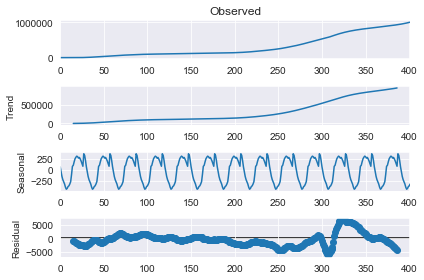

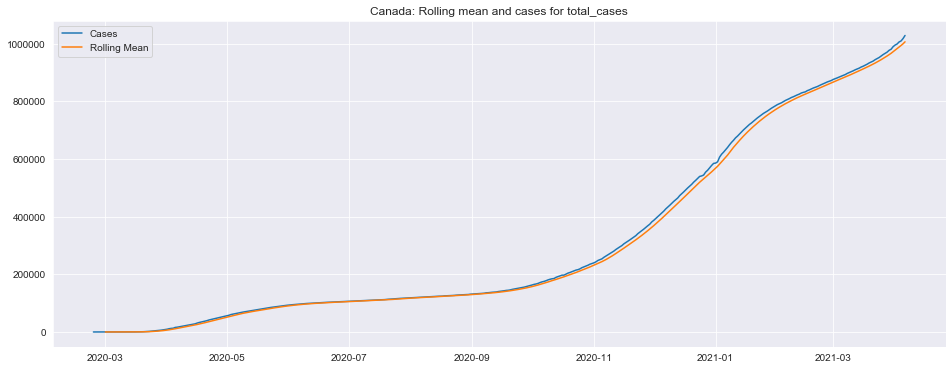

In [911]:
stationarity(cra('Canada').total_cases.values)
fig = sm.tsa.seasonal_decompose(cra('Canada').values, period = 30).plot()
crplot('Canada')

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic              2.497709
p-value                     0.999049
Lags Used                  16.000000
Number of Observations    376.000000
dtype: float64


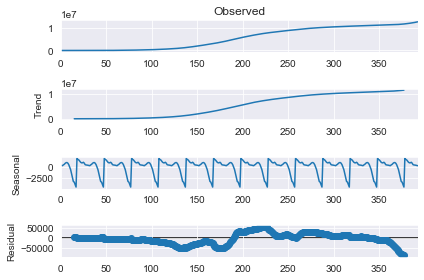

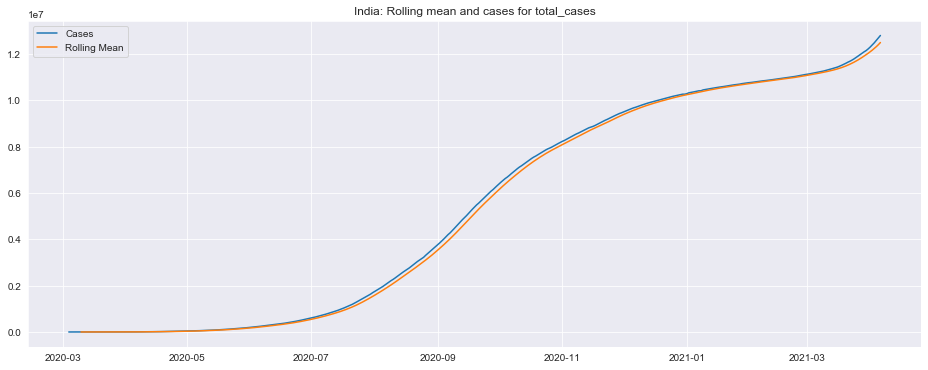

In [919]:
#other countries for curiosity
stationarity(cra('India').total_cases.values)
fig = sm.tsa.seasonal_decompose(cra('India').values, period = 30).plot()
crplot('India')

Augmented Dickey-Fuller test: Canada's total_cases
Test Statistic             -0.525403
p-value                     0.886963
Lags Used                  18.000000
Number of Observations    416.000000
dtype: float64


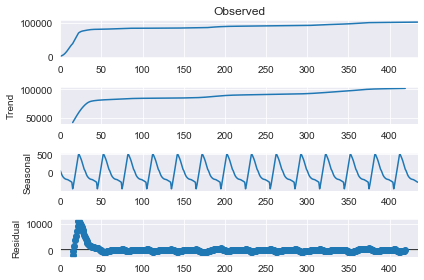

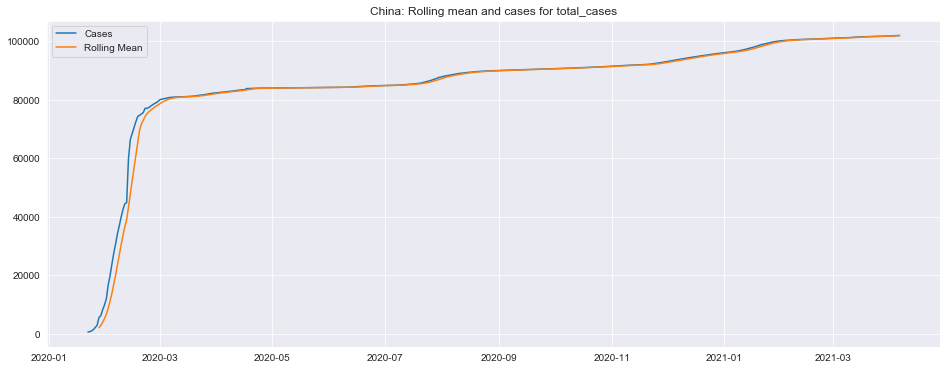

In [913]:
stationarity(cra('China').total_cases.values)
fig = sm.tsa.seasonal_decompose(cra('China').values, period = 30).plot()
crplot('China')

## ACF and PACF

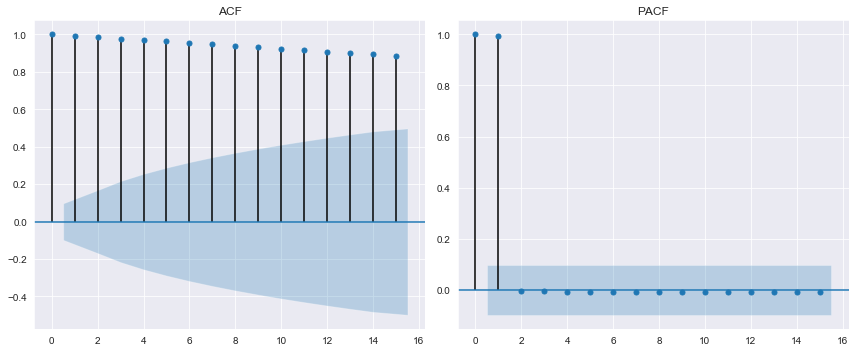

In [914]:
def autocorr(ts):
    plt.figure(figsize=(12,5))
    layout = (1, 2)
    
    ax_acf= plt.subplot2grid(layout, (0, 0))
    ax_pacf = plt.subplot2grid(layout, (0, 1))
    
    plot_acf(ts, lags=15, title='ACF', ax=ax_acf)
    plot_pacf(ts, lags=15, title='PACF', ax=ax_pacf)
    plt.tight_layout()
    
autocorr(cra('Canada'))
#ACF and PACF for Canada;

## ARIMA Modeling
- predictions using the model will be 30 days from today

In [433]:
from math import sqrt

In [916]:
#Train-test splitting on time series data
def split(ts):
    date = int(len(ts) * 0.85)
    train = ts[:date]
    test = ts[date:]
    return(train, test)

#(p,D,q) hyperparameter evaluation based on AIC
def arima(ts,test):
    p = d = q = range(0,6)
    x = 100000
    pdq = list(itertools.product(p,d,q))
    
    for combo in pdq:
        try:
            model = ARIMA(ts, order=combo)
            result = model.fit()
            if (result.aic <= x):
                x = result.aic
                param = combo
        except:
            continue
    return param

def rmse(y1, y_pred):
    y1, y_pred = np.array(y1), np.array(y_pred)
    return sqrt(mean_squared_error(y1, y_pred))

def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def ARIMAmodel(country, case):
    c1 = cra(country, case)
    series = c1[case].values
    train,test=split(series)
    pdq = arima(train,test)

    #Modeling
    model = ARIMA(train, order=pdq)
    result = model.fit()
    return result


In [917]:
def ARIMAfigs(result, case):
    
    c = cra('Canada',case=case)
    train, test = split(c[case].values)
    z, y = np.hstack(train), np.hstack(test)
    length = len(z) + len(y)
    zy = pd.DataFrame({'x':range(len(z)-10,len(z)+len(y)-10), 'y':y})
    zy.set_index('x', inplace=True)
    
    plt.figure(figsize=(15,10))
    layout=(1,1)

    days = 30 #days forecasted
    forecast = plt.subplot2grid(layout, (0,0))
    plt.setp(forecast, 
             xticks=[0,length/5,(length/5)*2,(length/5)*3,(length/5)*4,length-10,length+days],
             xticklabels=[str(c.index.min())[:10],'','','','',str(c.index.max())[:10],''])
    
    #Predict the test set + next 30 days
    result.plot_predict(start=10, end=length+days, ax=forecast)
    forecast.legend(fontsize='xx-large', loc='upper left')
    forecast.tick_params(axis='x', labelsize=15)
    forecast.tick_params(axis='y', labelsize=13)
    forecast.set_ylabel(f'COVID19 {case}', fontsize=15)
    forecast.set_title(f'ARIMA Model Predictions for COVID19 {case} in Canada', fontsize=20 )
    pred=result.forecast(steps=len(test))[0]
    
    #Model Error plots
    fig, ax = plt.subplots(1, 2, figsize=(16,4))

    ax[0].plot(pred, c='#1f77b4', label = 'Predicted')
    ax[0].plot(test, c='r', label = 'Actual')
    forecast.plot(zy, c='r', label = 'Actual')
    ax[1].plot(pred-y, c='purple', label = 'Residuals', marker='*')
    plt.setp(ax[0], xticks=[0, len(pred)], xticklabels=[str(c.index[len(z)+1])[:10], str(c.index.max())[:10]])
    ax[1].tick_params(axis='x', labelsize=13)
    fig.suptitle('ARIMA Model error', fontsize=20 )
    
    ax[1].annotate(f"RMSE:{rmse(test,pred):.3f}\nMAPE:{mape(test,pred):.3f}\n",
                   xy=(0.05, 0.55), fontsize=15,
                   xycoords = 'axes fraction', xytext=(0.05,0.55))
    
    forecast.legend(['Forecast', 'Actual', 'Actual(test set)', '95% CI'], loc = 'upper left', fontsize='xx-large')
    ax[0].legend(loc='upper left', fontsize='x-large')
    ax[1].legend(loc='upper left', fontsize='x-large')
    
    #creating the predictions list
    datelist = pd.date_range(c.index.max(), periods=days).tolist()
    dates = []
    for date in datelist:
        dates.append(str(date)[:10])
    oospred = result.forecast(steps=len(test)+days)[0]
    fpreds = pd.DataFrame({'Date':dates,'OOS Preds':oospred[len(test):]})
    
    print(result.summary(), '\n')
    print('Evaluation metrics:\n'
          f"RMSE:{rmse(test,pred):.3f}\n"
          f"MAPE:{mape(test,pred):.3f}\n")
    print(f'{days} day predictions\n', fpreds)

In [380]:
model_td = ARIMAmodel(country='Canada', case='total_deaths')
model_tc = ARIMAmodel(country='Canada', case='total_cases')

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  339
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -2123.264
Method:                       css-mle   S.D. of innovations            124.234
Date:                Thu, 08 Apr 2021   AIC                           4270.528
Time:                        00:50:45   BIC                           4316.440
Sample:                             2   HQIC                          4288.824
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1307     16.442      0.555      0.579     -23.095      41.356
ar.L1.D2.y     0.3002      0.114      2.633      0.008       0.077       0.524
ar.L2.D2.y     0.2762      0.061      4.518      0.0

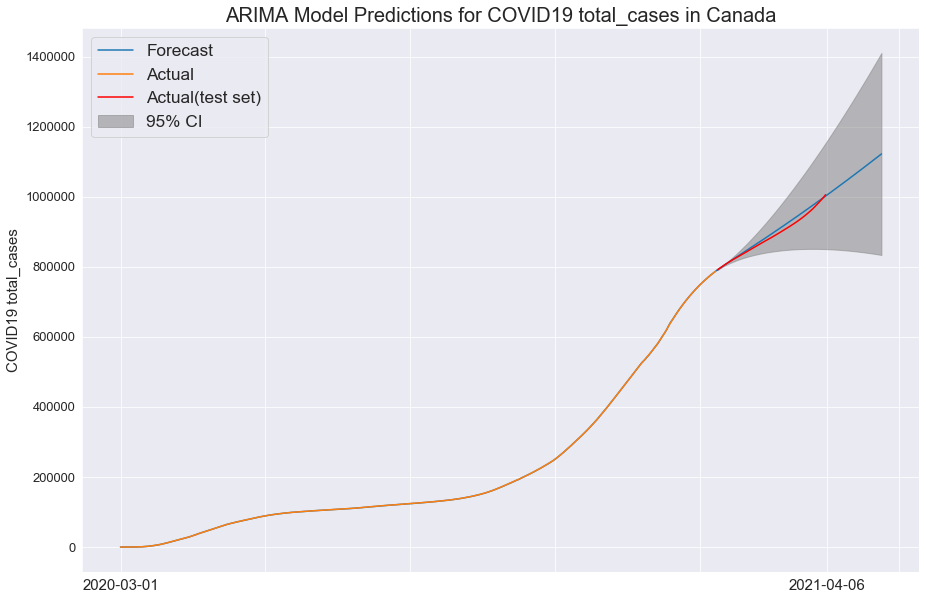

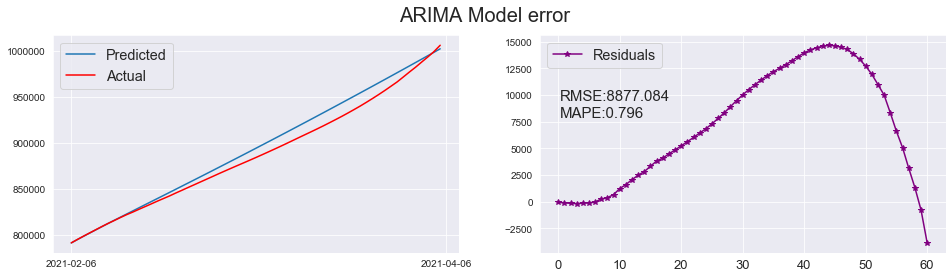

In [918]:
ARIMAfigs(model_tc, case='total_cases')

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  320
Model:                 ARIMA(5, 2, 4)   Log Likelihood                -827.370
Method:                       css-mle   S.D. of innovations              3.167
Date:                Wed, 07 Apr 2021   AIC                           1676.740
Time:                        20:34:13   BIC                           1718.191
Sample:                             2   HQIC                          1693.292
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1693      0.814      0.208      0.835      -1.426       1.765
ar.L1.D2.y     0.5526      0.155      3.560      0.000       0.248       0.857
ar.L2.D2.y    -0.4875      0.134     -3.651      0.0

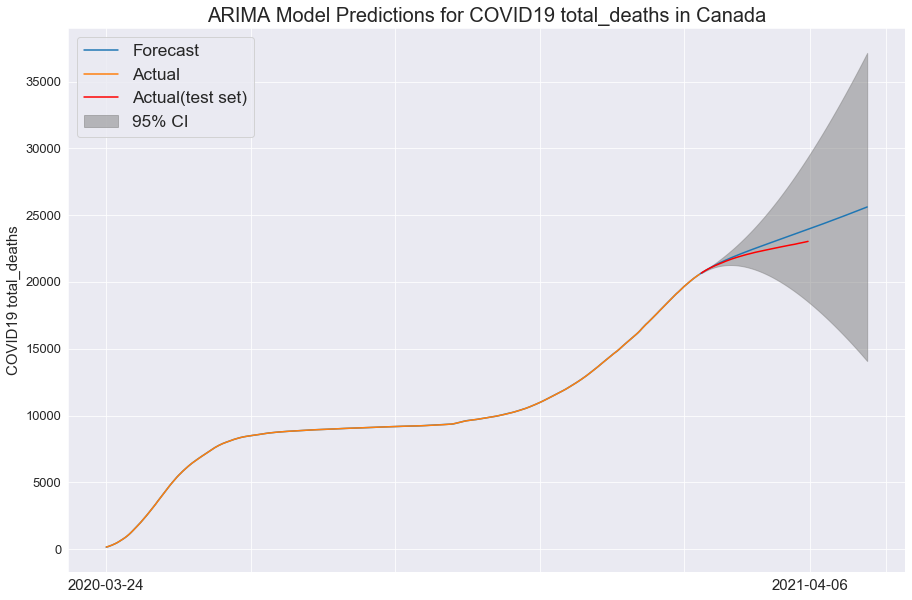

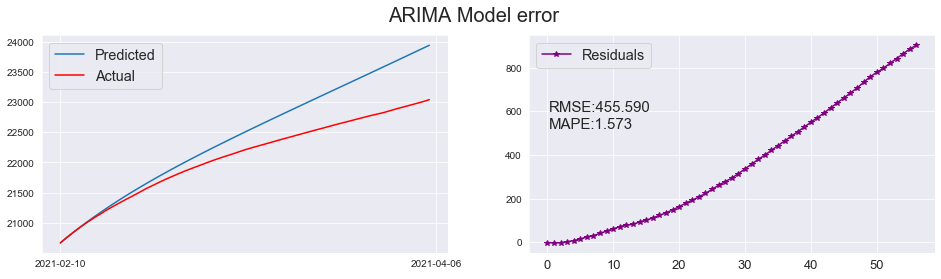

In [484]:
ARIMAfigs(model_td, case='total_deaths')

- The ARIMA(5,2,5) for cases and ARIMA(5,2,4) for deaths were relatively robust for the first 30 days and predicted the trajectory of COVID19 with moderate succuss
- ARIMA as a time series model is very useful, but with a pandemic like COVID19, a multivariate approach may be better

# Summary
- Top attributes related to COVID19 spread and fatality
- For COVID19 deaths; Median age; GDP, HDI, Life expectancy; Female Smoker; vaccinations
- For COVID19 cases: total tests, population density